In [2]:
# TODO:
# 1. Update bert 0.6.1 vs 0.4.0  See https://github.com/huggingface/pytorch-pretrained-BERT/issues/328
# 2. add crf on the top bert
# +3. calculate probability of a sequence
# 4. Try CRF with features from ACL paper
# 5. Try other dataset (CONLL-2003, OntoNotes 5.0)
# +7. Draw plots for CAD, HYP, DIABETES
# +8. Try document-level annotations
# 9. Create Bi-LSTM CRF baseline using Flair       <================
# 10. Разобраться с тем как оценивали участники результаты на проверочном корпусе What is evaluated in i2b2 ? 

# 11. Take small amount of unannotated data, build dictionary and try to outperform the dictionary baseline
# 12. Show that language models are super cool for active learning since you can use just a shallow architecture for training (faster)
# 13. Just show that bert kills old baselines.
# 14. Unlexicalized BERT for active learning (Poked bert delex.py)
# 15. Propose a self-attention network for tagging and show it is better than LSTM
# + 16. New variants of ranking procedure. Most uncertain among those that get positive labels. Most uncertain among tokens that have positive labels. 
# (yeah it seems to work at some point)

# Calculate % of data by using number of tokens.
# Use dictionary-based procedure to generate first annotated dataset
# + Token evaluation metrics
# + Try BERT without fine tuning Работает так себе ~45% f1
# + evaluate bert on test data
# Посмотреть, как работают скрипты оценки качества в i2b2
# Fix sentence splitting procedure <===================
# Fine-tune bert model and train only classifier https://github.com/huggingface/pytorch-pretrained-BERT/tree/master/examples/lm_finetuning
# Fix performance issue: generate batch with the length of the biggest sentence in batch
# Implement early stopping on dev set <=====================
# + Rerun all experiments with bert on new test data 
# Fix AL pipeline: retrain model from scratch, etc. <========================
# Widget: implement updating of text field with selection in Javascript. Then activate text field and   catch callback in python
# Check how we can deal with gpu memory allocation problem
# Make charts to plot several strategies at once <========================

In [1]:
!pip show pytorch-pretrained-bert

Name: pytorch-pretrained-bert
Version: 0.4.0
Summary: PyTorch version of Google AI BERT model with script to load Google pre-trained models
Home-page: https://github.com/huggingface/pytorch-pretrained-BERT
Author: Thomas Wolf, Victor Sanh, Tim Rault, Google AI Language Team Authors
Author-email: thomas@huggingface.co
License: Apache
Location: /root/.pyenv/versions/3.6.7/lib/python3.6/site-packages
Requires: numpy, requests, torch, tqdm, boto3
Required-by: flair


In [2]:
!pip install seqeval

In [3]:
!pip install pytorch-pretrained-bert==0.4.0

In [4]:
!pip install git+https://github.com/IINemo/libact.git@seq

  Cloning https://github.com/IINemo/libact.git (to revision seq) to /tmp/pip-req-build-ijlde1lk
  Running command git clone -q https://github.com/IINemo/libact.git /tmp/pip-req-build-ijlde1lk
  Running command git checkout -b seq --track origin/seq
  Switched to a new branch 'seq'
  Branch seq set up to track remote branch seq from origin.
  Stored in directory: /tmp/pip-ephem-wheel-cache-taalp7eo/wheels/43/f8/6d/9e686dbc90eb0c3a91ceee9e382e6ab85954d9a83459bced85
Successfully built libact


In [5]:
#!pip install -e ./packages/libact/
!pip uninstall -y actleto
!pip install git+https://github.com/IINemo/active_learning_toolbox.git@seq

Uninstalling actleto-0.1.0:
  Successfully uninstalled actleto-0.1.0
  Cloning https://github.com/IINemo/active_learning_toolbox.git (to revision seq) to /tmp/pip-req-build-soz1ziql
  Running command git clone -q https://github.com/IINemo/active_learning_toolbox.git /tmp/pip-req-build-soz1ziql
  Running command git checkout -b seq --track origin/seq
  Switched to a new branch 'seq'
  Branch seq set up to track remote branch seq from origin.
  Stored in directory: /tmp/pip-ephem-wheel-cache-xh742wf2/wheels/96/c0/0a/e37cee1f7228329c68c9185d15c632f7837f1ef5a863116bd8
Successfully built actleto


# Initialization

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import sys

#sys.path += ['./active_learning_toolbox/']

In [3]:
import torch

device = torch.device("cuda")
n_gpu = torch.cuda.device_count()

for i in range(n_gpu):
    print(torch.cuda.get_device_name(i))


GeForce GTX 1080 Ti


In [4]:
# if len(device) > 1:
#   model = nn.DataParallel(model, device_ids=[0, 1, 2])
#   model.cuda()
# else:
#     model = model.cuda()
#criterion = nn.DataParallelCriterion(criterion, device_ids=[0, 1, 2])

In [5]:
import logging
logger = logging.getLogger('biomed_ie')

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

#biomed2/biomed_ie/Logs/conll03_per.log
#fhandler = logging.FileHandler(filename='../Logs/Aconll03.log', mode='a')

#biomed2/biomed_ie/Logs/conll03_org.log
fhandler = logging.FileHandler(filename='../Logs/biocre.log', mode='a')

fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.setLevel(logging.DEBUG)

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json

# Global parameters

In [7]:
CACHE_DIR = '../workdir/models/0.4.0'

# MAX_LEN = 150
BATCH_SIZE = 25
MAX_LEN = 100
#BATCH_SIZE = 100
#BATCH_SIZE_PRED = 1200 # 1600
BATCH_SIZE_PRED = 600 # 1600
random_state = 2019

# Load dataset

In [8]:
from i2b2_utils import drop_noise_samples, tokenize_and_generate_labels, split_train_test_by_document, create_tensors
from bert_utils import train, test, create_model_optimizer

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

from sklearn.model_selection import train_test_split

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [9]:
#biomed2/biomed_ie/data/bio/Biocreative2006.json
dataset = '../data/bio/Biocreative2006.json'
dataset = pd.read_json(dataset)
dataset.rename(index=str,columns={'phrases':'texts'}, 
                 inplace=True)
dataset.drop(columns=['Key'],inplace = True)
print(dataset.shape)
dataset['doc_ids'] = 1
dataset.head()

(15001, 2)


,texts,Gene_span,doc_ids
0,Comparison with alkaline phosphatases and 5-nu...,"[[16, 37], [42, 63]]",1
1,Pharmacologic aspects of neonatal hyperbilirub...,[],1
10,When the CO2 content reached 9 Vol% the animal...,[],1
100,A similar phenomenon has been reported in a fe...,[],1
1000,Brucellosis--1990,[],1


In [10]:
dataset.loc['0', 'Gene_span'][0]

[16, 37]

In [11]:
# dataset_path = '../data/conll2003/conll2003/conll_train.json'
# dataset = pd.read_json(dataset_path)
# dataset.rename(index=str,columns={'Corpus':'texts'}, 
#                 inplace=True)
# #Subsampling
# #dataset = dataset.iloc[0:7000]


# print(dataset.shape)
# dataset.head()

In [12]:
#attr_name = 'I-MISC'
attr_name = 'Gene_span'
#attr_name = 'I-PER'

selected_dataset = drop_noise_samples(dataset, attr_name)
selected_dataset.shape

(7676, 3)

In [22]:
from sklearn.model_selection import train_test_split
#train_selected_dataset, test_selected_dataset = split_train_test_by_document(selected_dataset, test_ratio=0.2)
train_selected_dataset, test_selected_dataset = train_test_split(selected_dataset,  test_size=0.2, random_state=42)

In [23]:
# dataset_test_path = '../data/conll2003/conll2003/conll_test_a.json'
# dataset_test = pd.read_json(dataset_test_path)
# dataset_test.rename(index=str,columns={'Corpus':'texts'}, 
#                 inplace=True)
# print(dataset_test.shape)
# dataset_test.head()

In [46]:
dataset_test = test_selected_dataset
train_selected_dataset.head()

,texts,Gene_span,doc_ids
10693,Structural analysis of the 5'-regulatory regio...,"[[65, 79], [159, 173]]",1
716,ROS x SRC (R) contains a 16-amino-acid deletio...,"[[0, 3], [6, 9], [0, 3], [105, 108]]",1
1416,The predicted amino acid sequence exhibited 70...,"[[68, 101], [130, 163], [180, 213], [215, 248]]",1
13574,"Stress-activated protein kinase 1 (SAPK1), als...","[[0, 33], [35, 68], [55, 88], [80, 113]]",1
12204,A G22V mutant of M-Ras was constitutively acti...,"[[2, 13], [17, 28], [74, 85], [89, 100], [89, ...",1


In [25]:
test_selected_dataset.head()

,texts,Gene_span,doc_ids
8180,"ORF E8 colinear with ORF E6, which could gener...","[[0, 6], [21, 27]]",1
8268,Vacuolar membrane vesicles from hum1 mutants l...,"[[32, 44], [100, 112]]",1
14021,"In strains lacking tup11 and tup12, the atf1-p...","[[19, 24], [29, 34], [40, 45], [45, 50], [112,...",1
7560,We have examined the ability of various NF-kap...,"[[40, 59], [109, 128]]",1
5750,Although further studies are required to deter...,"[[71, 76], [84, 89], [191, 196]]",1


In [26]:
# test_selected_dataset = drop_noise_samples(dataset_test, attr_name)
# train_selected_dataset = selected_dataset
print('train', train_selected_dataset.shape)
print('test', test_selected_dataset.shape)

train (6140, 3)
test (1536, 3)


# Prepare model and preprocessing

In [27]:
from isanlp.en.processor_tokenizer_nltk_en import ProcessorTokenizerNltkEn

word_tokenizer = ProcessorTokenizerNltkEn()
bpe_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', cache_dir=CACHE_DIR, do_lower_case=False)
train_sents, train_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, train_selected_dataset, attr_name, MAX_LEN)
test_sents, test_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, test_selected_dataset, attr_name, MAX_LEN)

In [28]:
tags_vals = ['B', 'I', 'O', 'X', '[CLS]', '[SEP]']
tag2idx = {t : i for i, t in enumerate(tags_vals)}

In [29]:
train_input_ids, train_tags, train_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                    train_sents, train_labels, MAX_LEN)
test_input_ids, test_tags, test_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                 test_sents, test_labels, MAX_LEN)

In [15]:
# def create_model_optimizer(tag2idx, full_finetuning=True):
#     model = BertForTokenClassification.from_pretrained('bert-base-cased', 
#                                                        cache_dir=CACHE_DIR, 
#                                                        num_labels=len(tag2idx))
#     model.cuda()
    
#     lr_head = 5e-4
#     #lr_head = 5e-2
#     lr_body = 5e-5
#     weight_decay = 0.01
    
#     no_decay = ['bias', 'gamma', 'beta']

#     if full_finetuning:
#         param_optimizer = list(model.bert.named_parameters())
#         optimizer_grouped_parameters = [
#             {'params': [p for n, p in param_optimizer 
#                         if not any(nd in n for nd in no_decay)],
#              'weight_decay': weight_decay},
#             {'params': [p for n, p in param_optimizer 
#                         if any(nd in n for nd in no_decay)],
#              'weight_decay': 0.0},
#             {'params' : [p for n, p in model.classifier.named_parameters()
#                          if not any(nd in n for nd in no_decay)],
#              'lr' : lr_head,
#              'weight_decay': weight_decay},
#             {'params' : [p for n, p in model.classifier.named_parameters()
#                         if any(nd in n for nd in no_decay)],
#              'lr' : lr_head,
#              'weight_decay' : 0.0
#             }
#         ]
#     else:
#         param_optimizer = list(model.classifier.named_parameters()) 
#         optimizer_grouped_parameters = [
#             {'params' : [p for n, p in param_optimizer
#                          if not any(nd in n for nd in no_decay)],
#              'lr' : lr_head,
#              'weight_decay': weight_decay},
#             {'params' : [p for n, p in param_optimizer
#                          if any(nd in n for nd in no_decay)],
#              'lr' : lr_head,
#              'weight_decay' : 0.0
#             }
#         ]

#     optimizer = BertAdam(optimizer_grouped_parameters, lr=lr_body)
#     lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
#     #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
    
#     return model, optimizer, lr_scheduler

# Training

In [30]:
from i2b2_utils import subsample_dataset

train_input_ids, train_tags, train_attention_masks = subsample_dataset(train_input_ids, train_tags, 
                                                                       train_attention_masks, 
                                                                       positive_tag=tag2idx['B'], 
                                                                       negative_ratio=0.1, positive_ratio=1.)

In [31]:
logger.info('Creating model...')
model, optimizer, lr_scheduler = create_model_optimizer(tag2idx, full_finetuning=True)
logger.info('Done.')

t_tr_inputs = torch.tensor(train_input_ids)
t_tr_tags = torch.tensor(train_tags)
t_tr_masks = torch.tensor(train_attention_masks)

t_val_inputs = torch.tensor(test_input_ids)
t_val_tags = torch.tensor(test_tags)
t_val_masks = torch.tensor(test_attention_masks)

train_data = TensorDataset(t_tr_inputs, t_tr_masks, t_tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(t_val_inputs, t_val_masks, t_val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE_PRED, shuffle=False)

train(model, optimizer, lr_scheduler, train_dataloader, valid_dataloader, 
      epochs=20, device=device, tags_vals=tags_vals, early_stopping=1)

2019-08-13 07:10:07,146 - biomed_ie - INFO - Creating model...
2019-08-13 07:10:15,803 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:10:15,807 - biomed_ie - INFO - N parameters: 108314886
2019-08-13 07:10:15,808 - biomed_ie - INFO - Done.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

2019-08-13 07:11:33,901 - biomed_ie - INFO - Train loss: 0.008973975582408075
2019-08-13 07:11:38,838 - biomed_ie - INFO - Validation loss: 0.0003044388935675352
2019-08-13 07:11:39,820 - biomed_ie - INFO - Validation F1-Score: 0.6648827044866649
2019-08-13 07:11:39,861 - biomed_ie - INFO - Validatin accuracy: 0.9669490105269573


Epoch:   5%|▌         | 1/20 [01:24<26:37, 84.06s/it]

2019-08-13 07:12:59,874 - biomed_ie - INFO - Train loss: 0.0031184524652224333
2019-08-13 07:13:04,793 - biomed_ie - INFO - Validation loss: 0.00030637155761682294
2019-08-13 07:13:05,766 - biomed_ie - INFO - Validation F1-Score: 0.6779059449866902
2019-08-13 07:13:05,806 - biomed_ie - INFO - Validatin accuracy: 0.9714203013360552


# Active learning

In [32]:
from actleto import ActiveLearner, make_libact_strategy_ctor
from libact.query_strategies import UncertaintySampling, RandomSampling
from active_learning_seq import LibActNN, f1_score_wrapper, RandomSamplingWithRetraining, LibActNNPositiveLessCertain


def initialize_seeds(train_input_ids, train_tags, tags_vals, n_seeds_per_class=10):
    indexes = np.array(range(train_tags.shape[0]))
    known_indexes = []
    for label in range(len(tags_vals)):
        selected_indices = indexes[(train_tags == label).astype('float').sum(axis=1) != 0]
        known_indexes += list(np.random.choice(selected_indices, size=n_seeds_per_class))

    known_indexes = list(set(known_indexes))
    print(len(known_indexes))
    tags_seed = [None for _ in range(train_tags.shape[0])]

    for i in known_indexes:
        tags_seed[i] = train_tags[i]

    Y_seed = tags_seed
    X_train = train_input_ids
    
    return X_train, Y_seed
    

def create_active_learner(X_train, Y_seed, 
                          X_test, y_test, 
                          tags_vals,
                          libact_model, 
                          ranking_strategy,
                          rnd_steps=0):
    max_samples_number = 20
    random_state = 42

    active_learn_alg_ctor = make_libact_strategy_ctor(lambda tr_ds: ranking_strategy(tr_ds, libact_model), 
                                                      max_samples_number=max_samples_number)
    
    def _f1_score(a,b):
        return f1_score_wrapper(tags_vals, a,b)

    # Creating ActiveLearning object that implements AL logic.
    active_learner = ActiveLearner(active_learn_alg_ctor = active_learn_alg_ctor,
                                   y_dtype = 'int',
                                   X_full_dataset = X_train, 
                                   y_full_dataset = Y_seed,
                                   X_test_dataset = X_test,
                                   y_test_dataset = y_test,
                                   model_evaluate=libact_model,
                                   eval_metrics=[_f1_score],
                                   rnd_start_steps=rnd_steps, 
                                   rnd_start_samples=max_samples_number)
    
    return active_learner


def emulate_active_learning(train_tags, 
                            active_learner, 
                            max_iterations=12, 
                            n_annotations_per_iter=20):
    logger.info('Start emulating active learning.')
    active_learner.start()
    logger.info(f'Evaluation: {active_learner.evaluate(fit_model=False)}')

    statistics = []
    for i in range(max_iterations):
        logger.info(f'Active learning iteration: #{i}')
        samples_to_annotate = active_learner.choose_samples_for_annotation()
        active_learner.make_iteration(samples_to_annotate, train_tags[samples_to_annotate])
        perf = active_learner.evaluate(fit_model=False)
        statistics.append(perf)
        logger.info(f'Performance: {perf}')
    
    return statistics

## Perform single emulation of AL

In [37]:
model, optimizer, lr_scheduler = create_model_optimizer(tag2idx)
libact_model = LibActNN(model_ctor=(lambda : create_model_optimizer(tag2idx)),
                                device=device, 
                                batch_size=BATCH_SIZE,
                                bs_pred=BATCH_SIZE_PRED,
                                train_from_scratch=True,
                                retrain_epochs=30,
                                early_stopping=3)

2019-08-13 07:17:51,793 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:17:51,797 - biomed_ie - INFO - N parameters: 108314886


In [38]:
np.random.seed(42)

In [39]:
X_train, Y_seed = initialize_seeds(train_input_ids, train_tags, tags_vals)

59


In [40]:
ranking_strategy = lambda trn_ds, libact_model: UncertaintySampling(trn_ds, model=libact_model, method='lc')
#ranking_strategy = lambda trn_ds, libact_model: RandomSamplingWithRetraining(trn_ds, libact_model)

active_learner = create_active_learner(X_train, Y_seed, test_input_ids, test_tags, tags_vals, 
                                       libact_model=libact_model, ranking_strategy=ranking_strategy, rnd_steps=1)

In [35]:
statistics = emulate_active_learning(train_tags,active_learner)

2019-06-27 14:03:53,486 - biomed_ie - INFO - Start emulating active learning.
2019-06-27 14:03:59,286 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:03:59,290 - biomed_ie - INFO - N parameters: 108314886



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:03:59,910 - biomed_ie - INFO - Train loss: 0.26068915196550574
2019-06-27 14:03:59,960 - biomed_ie - INFO - Validation loss: 0.1216114069074894



Epoch:   3%|▎         | 1/30 [00:00<00:19,  1.51it/s]

2019-06-27 14:04:00,542 - biomed_ie - INFO - Train loss: 0.06371415485211505
2019-06-27 14:04:00,593 - biomed_ie - INFO - Validation loss: 0.06034849368361912



Epoch:   7%|▋         | 2/30 [00:01<00:18,  1.53it/s]

2019-06-27 14:04:01,183 - biomed_ie - INFO - Train loss: 0.03181295999424245
2019-06-27 14:04:01,234 - biomed_ie - INFO - Validation loss: 0.03827281973578713



Epoch:  10%|█         | 3/30 [00:01<00:17,  1.54it/s]

2019-06-27 14:04:01,816 - biomed_ie - INFO - Train loss: 0.014405999696109355
2019-06-27 14:04:01,866 - biomed_ie - INFO - Validation loss: 0.022111918388392385



Epoch:  13%|█▎        | 4/30 [00:02<00:16,  1.55it/s]

2019-06-27 14:04:02,450 - biomed_ie - INFO - Train loss: 0.006753914777522649
2019-06-27 14:04:02,501 - biomed_ie - INFO - Validation loss: 0.018973319919823796



Epoch:  17%|█▋        | 5/30 [00:03<00:16,  1.56it/s]

2019-06-27 14:04:03,084 - biomed_ie - INFO - Train loss: 0.0026926463583438866
2019-06-27 14:04:03,135 - biomed_ie - INFO - Validation loss: 0.013956255734167514



Epoch:  20%|██        | 6/30 [00:03<00:15,  1.56it/s]

2019-06-27 14:04:03,719 - biomed_ie - INFO - Train loss: 0.0009439051306496065
2019-06-27 14:04:03,770 - biomed_ie - INFO - Validation loss: 0.013671686201785951



Epoch:  23%|██▎       | 7/30 [00:04<00:14,  1.57it/s]

2019-06-27 14:04:04,352 - biomed_ie - INFO - Train loss: 0.0005526568009934532
2019-06-27 14:04:04,403 - biomed_ie - INFO - Validation loss: 0.01915524453426451



Epoch:  27%|██▋       | 8/30 [00:05<00:13,  1.57it/s]

2019-06-27 14:04:04,989 - biomed_ie - INFO - Train loss: 0.00026453921961317947
2019-06-27 14:04:05,039 - biomed_ie - INFO - Validation loss: 0.020435917808953357



Epoch:  30%|███       | 9/30 [00:05<00:13,  1.57it/s]

2019-06-27 14:04:05,626 - biomed_ie - INFO - Train loss: 0.0009699198379506911
2019-06-27 14:04:05,677 - biomed_ie - INFO - Validation loss: 0.018302363779408363
2019-06-27 14:04:12,774 - biomed_ie - INFO - Evaluation: {'_f1_score': 0.6693435754189944}
2019-06-27 14:04:12,775 - biomed_ie - INFO - Active learning iteration: #0
2019-06-27 14:04:19,996 - biomed_ie - INFO - Performance: {'_f1_score': 0.6693435754189944}
2019-06-27 14:04:19,997 - biomed_ie - INFO - Active learning iteration: #1
2019-06-27 14:04:25,770 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:04:25,773 - biomed_ie - INFO - N parameters: 108314886




Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:04:26,621 - biomed_ie - INFO - Train loss: 0.23321327445232293
2019-06-27 14:04:26,687 - biomed_ie - INFO - Validation loss: 0.07313309760575884




Epoch:   3%|▎         | 1/30 [00:00<00:26,  1.11it/s]

2019-06-27 14:04:27,504 - biomed_ie - INFO - Train loss: 0.0710120165658263
2019-06-27 14:04:27,569 - biomed_ie - INFO - Validation loss: 0.02900290020396201




Epoch:   7%|▋         | 2/30 [00:01<00:25,  1.12it/s]

2019-06-27 14:04:28,384 - biomed_ie - INFO - Train loss: 0.02270521506057796
2019-06-27 14:04:28,449 - biomed_ie - INFO - Validation loss: 0.010192812828535446




Epoch:  10%|█         | 3/30 [00:02<00:24,  1.12it/s]

2019-06-27 14:04:29,264 - biomed_ie - INFO - Train loss: 0.008901098265302226
2019-06-27 14:04:29,329 - biomed_ie - INFO - Validation loss: 0.005016483868775743




Epoch:  13%|█▎        | 4/30 [00:03<00:23,  1.13it/s]

2019-06-27 14:04:30,145 - biomed_ie - INFO - Train loss: 0.002786892788228492
2019-06-27 14:04:30,210 - biomed_ie - INFO - Validation loss: 0.0059623342384113355




Epoch:  17%|█▋        | 5/30 [00:04<00:22,  1.13it/s]

2019-06-27 14:04:31,026 - biomed_ie - INFO - Train loss: 0.001866556773287656
2019-06-27 14:04:31,091 - biomed_ie - INFO - Validation loss: 0.005338027487310131




Epoch:  20%|██        | 6/30 [00:05<00:21,  1.13it/s]

2019-06-27 14:04:31,906 - biomed_ie - INFO - Train loss: 0.0007420420632818817
2019-06-27 14:04:31,971 - biomed_ie - INFO - Validation loss: 0.0061196302262584825


2019-06-27 14:04:54,953 - biomed_ie - INFO - Performance: {'_f1_score': 0.6376447607088043}
2019-06-27 14:04:54,954 - biomed_ie - INFO - Active learning iteration: #2
2019-06-27 14:05:00,762 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:05:00,766 - biomed_ie - INFO - N parameters: 108314886




Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:05:01,746 - biomed_ie - INFO - Train loss: 0.13497155100202407
2019-06-27 14:05:01,828 - biomed_ie - INFO - Validation loss: 0.041248045099063185




Epoch:   3%|▎         | 1/30 [00:01<00:30,  1.05s/it]

2019-06-27 14:05:02,790 - biomed_ie - INFO - Train loss: 0.03388967043675554
2019-06-27 14:05:02,873 - biomed_ie - INFO - Validation loss: 0.019327283218463887




Epoch:   7%|▋         | 2/30 [00:02<00:29,  1.05s/it]

2019-06-27 14:05:03,836 - biomed_ie - INFO - Train loss: 0.014445293670930802
2019-06-27 14:05:03,918 - biomed_ie - INFO - Validation loss: 0.010336046730439493




Epoch:  10%|█         | 3/30 [00:03<00:28,  1.05s/it]

2019-06-27 14:05:04,862 - biomed_ie - INFO - Train loss: 0.005139608438998556
2019-06-27 14:05:04,945 - biomed_ie - INFO - Validation loss: 0.006379710701037579




Epoch:  13%|█▎        | 4/30 [00:04<00:27,  1.04s/it]

2019-06-27 14:05:05,902 - biomed_ie - INFO - Train loss: 0.0018314615014000252
2019-06-27 14:05:05,984 - biomed_ie - INFO - Validation loss: 0.004357435395867805




Epoch:  17%|█▋        | 5/30 [00:05<00:25,  1.04s/it]

2019-06-27 14:05:06,942 - biomed_ie - INFO - Train loss: 0.0007004411995244293
2019-06-27 14:05:07,024 - biomed_ie - INFO - Validation loss: 0.009898744582191227




Epoch:  20%|██        | 6/30 [00:06<00:24,  1.04s/it]

2019-06-27 14:05:07,982 - biomed_ie - INFO - Train loss: 0.0004417077097416924
2019-06-27 14:05:08,064 - biomed_ie - INFO - Validation loss: 0.005976462692726316




Epoch:  23%|██▎       | 7/30 [00:07<00:23,  1.04s/it]

2019-06-27 14:05:09,026 - biomed_ie - INFO - Train loss: 0.00014594436343089815
2019-06-27 14:05:09,109 - biomed_ie - INFO - Validation loss: 0.006617122669545371
2019-06-27 14:05:32,167 - biomed_ie - INFO - Performance: {'_f1_score': 0.7041960947237225}
2019-06-27 14:05:32,168 - biomed_ie - INFO - Active learning iteration: #3
2019-06-27 14:05:37,943 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:05:37,947 - biomed_ie - INFO - N parameters: 108314886





Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:05:39,184 - biomed_ie - INFO - Train loss: 0.10143427924395294
2019-06-27 14:05:39,282 - biomed_ie - INFO - Validation loss: 0.024099955267279687





Epoch:   3%|▎         | 1/30 [00:01<00:38,  1.32s/it]

2019-06-27 14:05:40,462 - biomed_ie - INFO - Train loss: 0.0227862210026392
2019-06-27 14:05:40,559 - biomed_ie - INFO - Validation loss: 0.00983157813766577





Epoch:   7%|▋         | 2/30 [00:02<00:36,  1.30s/it]

2019-06-27 14:05:41,737 - biomed_ie - INFO - Train loss: 0.006861641562895405
2019-06-27 14:05:41,835 - biomed_ie - INFO - Validation loss: 0.006010735502643306





Epoch:  10%|█         | 3/30 [00:03<00:34,  1.30s/it]

2019-06-27 14:05:43,017 - biomed_ie - INFO - Train loss: 0.0020392636314936264
2019-06-27 14:05:43,114 - biomed_ie - INFO - Validation loss: 0.0055678317962336715





Epoch:  13%|█▎        | 4/30 [00:05<00:33,  1.29s/it]

2019-06-27 14:05:44,295 - biomed_ie - INFO - Train loss: 0.0009298568956489523
2019-06-27 14:05:44,393 - biomed_ie - INFO - Validation loss: 0.006060704697657676





Epoch:  17%|█▋        | 5/30 [00:06<00:32,  1.29s/it]

2019-06-27 14:05:45,583 - biomed_ie - INFO - Train loss: 0.00034209883299465653
2019-06-27 14:05:45,681 - biomed_ie - INFO - Validation loss: 0.006989512701321692





Epoch:  20%|██        | 6/30 [00:07<00:30,  1.29s/it]

2019-06-27 14:05:46,865 - biomed_ie - INFO - Train loss: 0.0003456341415396771
2019-06-27 14:05:46,962 - biomed_ie - INFO - Validation loss: 0.0068146565480388865
2019-06-27 14:06:09,973 - biomed_ie - INFO - Performance: {'_f1_score': 0.7074531012337333}
2019-06-27 14:06:09,974 - biomed_ie - INFO - Active learning iteration: #4
2019-06-27 14:06:15,736 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:06:15,740 - biomed_ie - INFO - N parameters: 108314886






Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:06:17,182 - biomed_ie - INFO - Train loss: 0.09247383496459409
2019-06-27 14:06:17,290 - biomed_ie - INFO - Validation loss: 0.014979592655404661






Epoch:   3%|▎         | 1/30 [00:01<00:44,  1.53s/it]

2019-06-27 14:06:18,716 - biomed_ie - INFO - Train loss: 0.01918534910976409
2019-06-27 14:06:18,824 - biomed_ie - INFO - Validation loss: 0.004486972499684456






Epoch:   7%|▋         | 2/30 [00:03<00:42,  1.53s/it]

2019-06-27 14:06:20,228 - biomed_ie - INFO - Train loss: 0.003810532929348896
2019-06-27 14:06:20,336 - biomed_ie - INFO - Validation loss: 0.0035487306079335064






Epoch:  10%|█         | 3/30 [00:04<00:41,  1.52s/it]

2019-06-27 14:06:21,750 - biomed_ie - INFO - Train loss: 0.00246333705616647
2019-06-27 14:06:21,859 - biomed_ie - INFO - Validation loss: 0.0025536491661168038






Epoch:  13%|█▎        | 4/30 [00:06<00:39,  1.52s/it]

2019-06-27 14:06:23,264 - biomed_ie - INFO - Train loss: 0.0013745337202616134
2019-06-27 14:06:23,372 - biomed_ie - INFO - Validation loss: 0.0037465969714313937






Epoch:  17%|█▋        | 5/30 [00:07<00:38,  1.52s/it]

2019-06-27 14:06:24,783 - biomed_ie - INFO - Train loss: 0.0005930154107703833
2019-06-27 14:06:24,891 - biomed_ie - INFO - Validation loss: 0.002868218641532095






Epoch:  20%|██        | 6/30 [00:09<00:36,  1.52s/it]

2019-06-27 14:06:26,301 - biomed_ie - INFO - Train loss: 0.00024429958285765994
2019-06-27 14:06:26,409 - biomed_ie - INFO - Validation loss: 0.00368397583528311
2019-06-27 14:06:49,427 - biomed_ie - INFO - Performance: {'_f1_score': 0.7727526521496371}
2019-06-27 14:06:49,429 - biomed_ie - INFO - Active learning iteration: #5
2019-06-27 14:06:55,257 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:06:55,261 - biomed_ie - INFO - N parameters: 108314886







Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:06:56,858 - biomed_ie - INFO - Train loss: 0.09372226285198897
2019-06-27 14:06:56,984 - biomed_ie - INFO - Validation loss: 0.017453759890625073







Epoch:   3%|▎         | 1/30 [00:01<00:49,  1.70s/it]

2019-06-27 14:06:58,541 - biomed_ie - INFO - Train loss: 0.01894237611593916
2019-06-27 14:06:58,667 - biomed_ie - INFO - Validation loss: 0.0042521316379868284







Epoch:   7%|▋         | 2/30 [00:03<00:47,  1.69s/it]

2019-06-27 14:07:00,214 - biomed_ie - INFO - Train loss: 0.004522726039072828
2019-06-27 14:07:00,339 - biomed_ie - INFO - Validation loss: 0.001369460600387104







Epoch:  10%|█         | 3/30 [00:05<00:45,  1.69s/it]

2019-06-27 14:07:01,891 - biomed_ie - INFO - Train loss: 0.001689684996744992
2019-06-27 14:07:02,016 - biomed_ie - INFO - Validation loss: 0.0013428043544761778







Epoch:  13%|█▎        | 4/30 [00:06<00:43,  1.69s/it]

2019-06-27 14:07:03,572 - biomed_ie - INFO - Train loss: 0.000623607592292909
2019-06-27 14:07:03,698 - biomed_ie - INFO - Validation loss: 0.001414795194626721







Epoch:  17%|█▋        | 5/30 [00:08<00:42,  1.68s/it]

2019-06-27 14:07:05,254 - biomed_ie - INFO - Train loss: 0.00038164847983936654
2019-06-27 14:07:05,380 - biomed_ie - INFO - Validation loss: 0.0014706949693805732







Epoch:  20%|██        | 6/30 [00:10<00:40,  1.68s/it]

2019-06-27 14:07:06,933 - biomed_ie - INFO - Train loss: 0.00021051440066586133
2019-06-27 14:07:07,059 - biomed_ie - INFO - Validation loss: 0.001571506943253587
2019-06-27 14:07:29,980 - biomed_ie - INFO - Performance: {'_f1_score': 0.8221585482330468}
2019-06-27 14:07:29,981 - biomed_ie - INFO - Active learning iteration: #6
2019-06-27 14:07:35,784 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:07:35,788 - biomed_ie - INFO - N parameters: 108314886








Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:07:37,614 - biomed_ie - INFO - Train loss: 0.08181705244291419
2019-06-27 14:07:37,754 - biomed_ie - INFO - Validation loss: 0.009832758652536492








Epoch:   3%|▎         | 1/30 [00:01<00:56,  1.94s/it]

2019-06-27 14:07:39,547 - biomed_ie - INFO - Train loss: 0.012645860453831636
2019-06-27 14:07:39,687 - biomed_ie - INFO - Validation loss: 0.001743662924993606








Epoch:   7%|▋         | 2/30 [00:03<00:54,  1.94s/it]

2019-06-27 14:07:41,470 - biomed_ie - INFO - Train loss: 0.002932302344736624
2019-06-27 14:07:41,611 - biomed_ie - INFO - Validation loss: 0.0010407568518081703








Epoch:  10%|█         | 3/30 [00:05<00:52,  1.93s/it]

2019-06-27 14:07:43,394 - biomed_ie - INFO - Train loss: 0.0011835613854428084
2019-06-27 14:07:43,534 - biomed_ie - INFO - Validation loss: 0.0014192258056841397








Epoch:  13%|█▎        | 4/30 [00:07<00:50,  1.93s/it]

2019-06-27 14:07:45,318 - biomed_ie - INFO - Train loss: 0.0007986056493938531
2019-06-27 14:07:45,458 - biomed_ie - INFO - Validation loss: 0.002320630657941775








Epoch:  17%|█▋        | 5/30 [00:09<00:48,  1.93s/it]

2019-06-27 14:07:47,245 - biomed_ie - INFO - Train loss: 0.00087258713339946
2019-06-27 14:07:47,386 - biomed_ie - INFO - Validation loss: 0.0008875615241234763








Epoch:  20%|██        | 6/30 [00:11<00:46,  1.93s/it]

2019-06-27 14:07:49,168 - biomed_ie - INFO - Train loss: 0.0005084421619215259
2019-06-27 14:07:49,308 - biomed_ie - INFO - Validation loss: 0.0010866036914046245








Epoch:  23%|██▎       | 7/30 [00:13<00:44,  1.93s/it]

2019-06-27 14:07:51,093 - biomed_ie - INFO - Train loss: 0.00017252766309325458
2019-06-27 14:07:51,233 - biomed_ie - INFO - Validation loss: 0.0011823456127542005








Epoch:  27%|██▋       | 8/30 [00:15<00:42,  1.93s/it]

2019-06-27 14:07:53,027 - biomed_ie - INFO - Train loss: 0.00011307951682874117
2019-06-27 14:07:53,167 - biomed_ie - INFO - Validation loss: 0.0011382564752920527
2019-06-27 14:08:16,029 - biomed_ie - INFO - Performance: {'_f1_score': 0.7966983671272205}
2019-06-27 14:08:16,030 - biomed_ie - INFO - Active learning iteration: #7
2019-06-27 14:08:21,871 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:08:21,875 - biomed_ie - INFO - N parameters: 108314886









Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:08:23,841 - biomed_ie - INFO - Train loss: 0.07080782017891168
2019-06-27 14:08:23,997 - biomed_ie - INFO - Validation loss: 0.00832585760686646









Epoch:   3%|▎         | 1/30 [00:02<01:00,  2.09s/it]

2019-06-27 14:08:25,930 - biomed_ie - INFO - Train loss: 0.009324494011247476
2019-06-27 14:08:26,086 - biomed_ie - INFO - Validation loss: 0.002611017465899465









Epoch:   7%|▋         | 2/30 [00:04<00:58,  2.09s/it]

2019-06-27 14:08:28,025 - biomed_ie - INFO - Train loss: 0.0026101617419740687
2019-06-27 14:08:28,182 - biomed_ie - INFO - Validation loss: 0.0020891936571304395









Epoch:  10%|█         | 3/30 [00:06<00:56,  2.09s/it]

2019-06-27 14:08:30,103 - biomed_ie - INFO - Train loss: 0.0017843488849850389
2019-06-27 14:08:30,259 - biomed_ie - INFO - Validation loss: 0.002484956979238196









Epoch:  13%|█▎        | 4/30 [00:08<00:54,  2.09s/it]

2019-06-27 14:08:32,186 - biomed_ie - INFO - Train loss: 0.0009413199274551143
2019-06-27 14:08:32,343 - biomed_ie - INFO - Validation loss: 0.0020857236182042797









Epoch:  17%|█▋        | 5/30 [00:10<00:52,  2.09s/it]

2019-06-27 14:08:34,262 - biomed_ie - INFO - Train loss: 0.0004598661978508471
2019-06-27 14:08:34,418 - biomed_ie - INFO - Validation loss: 0.0021166284468336215









Epoch:  20%|██        | 6/30 [00:12<00:50,  2.08s/it]

2019-06-27 14:08:36,334 - biomed_ie - INFO - Train loss: 0.00014702556039760775
2019-06-27 14:08:36,491 - biomed_ie - INFO - Validation loss: 0.0021062773699702937









Epoch:  23%|██▎       | 7/30 [00:14<00:47,  2.08s/it]

2019-06-27 14:08:38,402 - biomed_ie - INFO - Train loss: 0.00028386013821534985
2019-06-27 14:08:38,559 - biomed_ie - INFO - Validation loss: 0.0020892380975013557
2019-06-27 14:09:01,412 - biomed_ie - INFO - Performance: {'_f1_score': 0.7773102171351626}
2019-06-27 14:09:01,414 - biomed_ie - INFO - Active learning iteration: #8
2019-06-27 14:09:07,143 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:09:07,147 - biomed_ie - INFO - N parameters: 108314886










Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:09:09,350 - biomed_ie - INFO - Train loss: 0.06184883947526977
2019-06-27 14:09:09,523 - biomed_ie - INFO - Validation loss: 0.004476115659431175










Epoch:   3%|▎         | 1/30 [00:02<01:07,  2.34s/it]

2019-06-27 14:09:11,612 - biomed_ie - INFO - Train loss: 0.006664199104777809
2019-06-27 14:09:11,786 - biomed_ie - INFO - Validation loss: 0.0011827677661470511










Epoch:   7%|▋         | 2/30 [00:04<01:04,  2.31s/it]

2019-06-27 14:09:13,921 - biomed_ie - INFO - Train loss: 0.0019095162059690192
2019-06-27 14:09:14,094 - biomed_ie - INFO - Validation loss: 0.0008855679883373415










Epoch:  10%|█         | 3/30 [00:06<01:02,  2.31s/it]

2019-06-27 14:09:16,236 - biomed_ie - INFO - Train loss: 0.000526519029912491
2019-06-27 14:09:16,408 - biomed_ie - INFO - Validation loss: 0.000973245684942129










Epoch:  13%|█▎        | 4/30 [00:09<01:00,  2.31s/it]

2019-06-27 14:09:18,553 - biomed_ie - INFO - Train loss: 0.0003007501198805283
2019-06-27 14:09:18,726 - biomed_ie - INFO - Validation loss: 0.0011618134816574204










Epoch:  17%|█▋        | 5/30 [00:11<00:57,  2.31s/it]

2019-06-27 14:09:20,868 - biomed_ie - INFO - Train loss: 0.0002521076778146247
2019-06-27 14:09:21,040 - biomed_ie - INFO - Validation loss: 0.0011100289029709741
2019-06-27 14:09:43,815 - biomed_ie - INFO - Performance: {'_f1_score': 0.7792952284606305}
2019-06-27 14:09:43,816 - biomed_ie - INFO - Active learning iteration: #9
2019-06-27 14:09:49,566 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:09:49,570 - biomed_ie - INFO - N parameters: 108314886











Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:09:51,989 - biomed_ie - INFO - Train loss: 0.04913146056274491
2019-06-27 14:09:52,178 - biomed_ie - INFO - Validation loss: 0.0030719040354694775











Epoch:   3%|▎         | 1/30 [00:02<01:14,  2.58s/it]

2019-06-27 14:09:54,552 - biomed_ie - INFO - Train loss: 0.005331777238866974
2019-06-27 14:09:54,741 - biomed_ie - INFO - Validation loss: 0.0025168544140110644











Epoch:   7%|▋         | 2/30 [00:05<01:12,  2.57s/it]

2019-06-27 14:09:57,118 - biomed_ie - INFO - Train loss: 0.0037269995480088496
2019-06-27 14:09:57,307 - biomed_ie - INFO - Validation loss: 0.0012462850438326586











Epoch:  10%|█         | 3/30 [00:07<01:09,  2.57s/it]

2019-06-27 14:09:59,670 - biomed_ie - INFO - Train loss: 0.0015252751712965442
2019-06-27 14:09:59,859 - biomed_ie - INFO - Validation loss: 0.000754555712895899











Epoch:  13%|█▎        | 4/30 [00:10<01:06,  2.57s/it]

2019-06-27 14:10:02,217 - biomed_ie - INFO - Train loss: 0.00041513509898584737
2019-06-27 14:10:02,406 - biomed_ie - INFO - Validation loss: 0.0006997002555728588











Epoch:  17%|█▋        | 5/30 [00:12<01:04,  2.56s/it]

2019-06-27 14:10:04,769 - biomed_ie - INFO - Train loss: 0.00017246534694856367
2019-06-27 14:10:04,959 - biomed_ie - INFO - Validation loss: 0.00080216358448259











Epoch:  20%|██        | 6/30 [00:15<01:01,  2.56s/it]

2019-06-27 14:10:07,323 - biomed_ie - INFO - Train loss: 8.826580924097073e-05
2019-06-27 14:10:07,512 - biomed_ie - INFO - Validation loss: 0.0008384178498547948











Epoch:  23%|██▎       | 7/30 [00:17<00:58,  2.56s/it]

2019-06-27 14:10:09,870 - biomed_ie - INFO - Train loss: 0.00015133472684372077
2019-06-27 14:10:10,059 - biomed_ie - INFO - Validation loss: 0.0007823806396459516
2019-06-27 14:10:32,727 - biomed_ie - INFO - Performance: {'_f1_score': 0.7957650273224044}
2019-06-27 14:10:32,728 - biomed_ie - INFO - Active learning iteration: #10
2019-06-27 14:10:38,538 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:10:38,542 - biomed_ie - INFO - N parameters: 108314886












Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:10:41,118 - biomed_ie - INFO - Train loss: 0.054863446511437125
2019-06-27 14:10:41,321 - biomed_ie - INFO - Validation loss: 0.00440427330458937












Epoch:   3%|▎         | 1/30 [00:02<01:19,  2.75s/it]

2019-06-27 14:10:43,755 - biomed_ie - INFO - Train loss: 0.006174810770466629
2019-06-27 14:10:43,959 - biomed_ie - INFO - Validation loss: 0.0015089011929779704












Epoch:   7%|▋         | 2/30 [00:05<01:15,  2.71s/it]

2019-06-27 14:10:46,457 - biomed_ie - INFO - Train loss: 0.00236215823036094
2019-06-27 14:10:46,661 - biomed_ie - INFO - Validation loss: 0.0011020511947756105












Epoch:  10%|█         | 3/30 [00:08<01:13,  2.71s/it]

2019-06-27 14:10:49,171 - biomed_ie - INFO - Train loss: 0.0010926295314080251
2019-06-27 14:10:49,375 - biomed_ie - INFO - Validation loss: 0.0007497436633899283












Epoch:  13%|█▎        | 4/30 [00:10<01:10,  2.71s/it]

2019-06-27 14:10:51,886 - biomed_ie - INFO - Train loss: 0.0007694009364152571
2019-06-27 14:10:52,089 - biomed_ie - INFO - Validation loss: 0.000713258741442488












Epoch:  17%|█▋        | 5/30 [00:13<01:07,  2.71s/it]

2019-06-27 14:10:54,596 - biomed_ie - INFO - Train loss: 0.0002924337894443554
2019-06-27 14:10:54,801 - biomed_ie - INFO - Validation loss: 0.0005735714489906075












Epoch:  20%|██        | 6/30 [00:16<01:05,  2.71s/it]

2019-06-27 14:10:57,309 - biomed_ie - INFO - Train loss: 0.00019329830139085832
2019-06-27 14:10:57,512 - biomed_ie - INFO - Validation loss: 0.0006695086453336758












Epoch:  23%|██▎       | 7/30 [00:18<01:02,  2.71s/it]

2019-06-27 14:11:00,025 - biomed_ie - INFO - Train loss: 8.377585363038195e-05
2019-06-27 14:11:00,228 - biomed_ie - INFO - Validation loss: 0.0007454006785270061












Epoch:  27%|██▋       | 8/30 [00:21<00:59,  2.71s/it]

2019-06-27 14:11:02,735 - biomed_ie - INFO - Train loss: 0.00010574174350606453
2019-06-27 14:11:02,938 - biomed_ie - INFO - Validation loss: 0.0007829931357770658
2019-06-27 14:11:25,596 - biomed_ie - INFO - Performance: {'_f1_score': 0.8219281663516068}
2019-06-27 14:11:25,597 - biomed_ie - INFO - Active learning iteration: #11
2019-06-27 14:11:31,339 - biomed_ie - INFO - Full finetuning: True
2019-06-27 14:11:31,343 - biomed_ie - INFO - N parameters: 108314886













Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-06-27 14:11:34,142 - biomed_ie - INFO - Train loss: 0.049872430936686606
2019-06-27 14:11:34,359 - biomed_ie - INFO - Validation loss: 0.0023352651199374003













Epoch:   3%|▎         | 1/30 [00:02<01:26,  2.98s/it]

2019-06-27 14:11:37,096 - biomed_ie - INFO - Train loss: 0.004352784316563091
2019-06-27 14:11:37,313 - biomed_ie - INFO - Validation loss: 0.0012252570728862326













Epoch:   7%|▋         | 2/30 [00:05<01:23,  2.97s/it]

2019-06-27 14:11:40,044 - biomed_ie - INFO - Train loss: 0.0012169965105097097
2019-06-27 14:11:40,260 - biomed_ie - INFO - Validation loss: 0.0010792809871979702













Epoch:  10%|█         | 3/30 [00:08<01:20,  2.97s/it]

2019-06-27 14:11:43,002 - biomed_ie - INFO - Train loss: 0.0003926792193228463
2019-06-27 14:11:43,220 - biomed_ie - INFO - Validation loss: 0.0014449982965567833













Epoch:  13%|█▎        | 4/30 [00:11<01:17,  2.96s/it]

2019-06-27 14:11:45,962 - biomed_ie - INFO - Train loss: 0.00021461625458654417
2019-06-27 14:11:46,179 - biomed_ie - INFO - Validation loss: 0.001288909678306644













Epoch:  17%|█▋        | 5/30 [00:14<01:14,  2.96s/it]

2019-06-27 14:11:48,907 - biomed_ie - INFO - Train loss: 0.00014916863647681389
2019-06-27 14:11:49,123 - biomed_ie - INFO - Validation loss: 0.0012352982145032766
2019-06-27 14:12:11,573 - biomed_ie - INFO - Performance: {'_f1_score': 0.8222548659566654}


In [41]:
import json

statistics_path = '../Logs/statistics_us.json'
#statistics_path = '../Logs/statistics_random.json'

with open(statistics_path, 'w') as f:
    json.dump(statistics, f)

NameError: name 'statistics' is not defined

In [37]:
with open('../Logs/statistics_us.json', 'r') as f:
    statistics_us = json.load(f)
    
with open('../Logs/statistics_random.json', 'r') as f:
    statistics_random = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../Logs/statistics_random.json'

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline 

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt1, = plt.plot(list(range(len(statistics))), [e['_f1_score'] for e in statistics_random], label='random')
plt2, = plt.plot(list(range(len(statistics_us))), [e['_f1_score'] for e in statistics_us], label='us')
plt.legend(handles=[plt1, plt2])
plt.title('Performance')
plt.show()

NameError: name 'statistics' is not defined

<Figure size 640x480 with 0 Axes>

## Multiple AL evaluations

In [42]:
def perform_several_al_passes(train_input_ids, train_tags, 
                              test_input_ids, test_tags, 
                              tags_vals, tag2index, 
                              ranking_strategy, fit_model, 
                              n_passes, n_al_iterations):
    stats = []
    for i in range(n_passes):
        logger.info('=============== Pass: {} ============='.format(i))
        
        np.random.seed(42 + i*3)
        
        libact_model = LibActNN(model_ctor=(lambda : create_model_optimizer(tag2idx)),
                                device=device, 
                                batch_size=BATCH_SIZE,
                                bs_pred=BATCH_SIZE_PRED,
                                train_from_scratch=True,
                                retrain_epochs=30,
                                early_stopping=3)
        
#         libact_model = LibActNNPositiveLessCertain(
#             tag2index['B'],
#             model_ctor=(lambda : create_model_optimizer(tag2index)), 
#             device=device, 
#             batch_size=BATCH_SIZE,
#             bs_pred=BATCH_SIZE_PRED,
#             train_from_scratch=False
#         )

        X_train, Y_seed = initialize_seeds(train_input_ids, train_tags, tags_vals)
        active_learner = create_active_learner(X_train, Y_seed, test_input_ids, test_tags, 
                                               tags_vals, libact_model, 
                                               ranking_strategy=ranking_strategy)
        
        statistics = emulate_active_learning(train_tags, 
                                             active_learner, 
                                             max_iterations=n_al_iterations)
        stats.append(statistics)
    
    return stats

In [43]:
#ranking_strategy = lambda trn_ds, libact_model: RandomSamplingWithRetraining(trn_ds, model=libact_model)
ranking_strategy = lambda trn_ds, libact_model: UncertaintySampling(trn_ds, model=libact_model, method='lc')
stats = perform_several_al_passes(ranking_strategy)

TypeError: perform_several_al_passes() missing 9 required positional arguments: 'train_tags', 'test_input_ids', 'test_tags', 'tags_vals', 'tag2index', 'ranking_strategy', 'fit_model', 'n_passes', and 'n_al_iterations'

In [11]:
us_stats = np.load('../workdir/experiments/hypertension_us.npy')
random_stats = np.load('../workdir/experiments/hypertension_random.npy')

In [26]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline 


def generate_plot(np_stats, color_bg, color_line, label):
    disp = np_stats.std(axis=0)
    means = np_stats.mean(axis=0)

    x = list(range(means.shape[0]))

    plt.fill_between(x, means - disp, means + disp, color=color_bg, alpha=0.5)
    return plt.plot(x, means, color=color_line, label=label)

In [27]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt1, = generate_plot(random_stats, color_bg='skyblue', color_line='midnightblue', label='random')
plt2, = generate_plot(us_stats, color_bg='darksalmon', color_line='red', label='US')

plt.legend(handles=[plt1, plt2])
plt.ylabel('Performance, F1')
plt.xlabel('AL iteration, #')
plt.show()

NameError: name 'random_stats' is not defined

<Figure size 640x480 with 0 Axes>

In [28]:
def create_char(expert_dir, attr_type):
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt_list = []
    
    for filename in os.listdir(expert_dir):
        f_type, f_strat = filename.split('_')
        if f_type != attr_type:
            continue
        
        file_path = os.path.join(expert_dir, filename)
        stats = np.load(file_path)
        plt, = generate_plot(random_stats, color_bg='skyblue', color_line='midnightblue', label=f_strat)
        plt_list.append(plt)
        
    plt.legend(handles=plt_list)
    plt.ylabel('Performance, F1')
    plt.xlabel('AL iteration, #')
    plt.show()

In [29]:
def create_chart(exper_dir, attr_type):
    us_stats = np.load(os.path.join(exper_dir, f'{attr_type}_us.npy'))
    random_stats = np.load(os.path.join(exper_dir, f'{attr_type}_random.npy'))
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    plt1, = generate_plot(random_stats, color_bg='skyblue', color_line='midnightblue', label='random')
    plt2, = generate_plot(us_stats, color_bg='darksalmon', color_line='red', label='US')

    plt.legend(handles=[plt1, plt2])
    plt.ylabel('Performance, F1')
    plt.xlabel('AL iteration, #')
    plt.show()

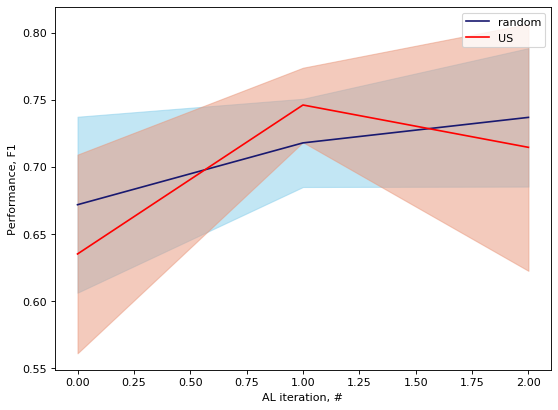

In [33]:
create_chart('../Logs/experiments_3/', 'i-org')
# Few epohs to run faster

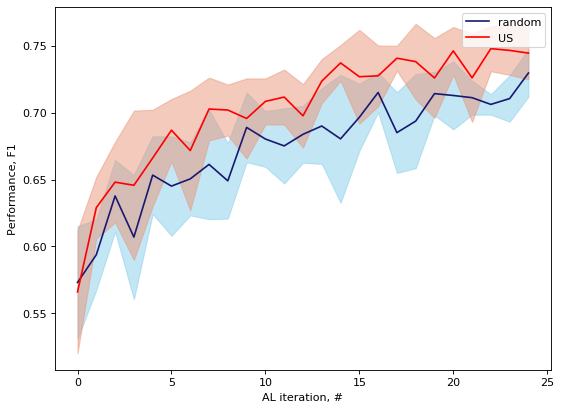

In [30]:
create_chart('../Logs/experiments_3/', 'i-misc')

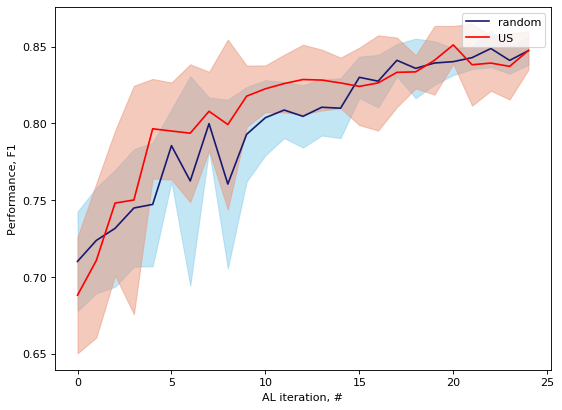

In [31]:
create_chart('../Logs/experiments', 'i-org')

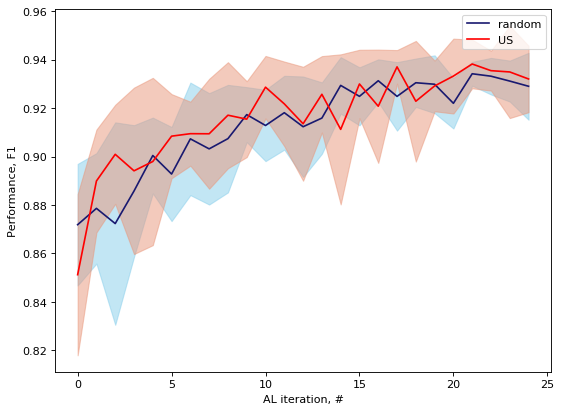

In [32]:
create_chart('../Logs/experiments', 'i-per')

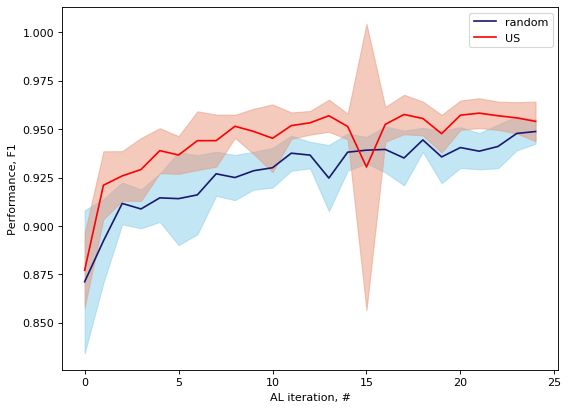

In [55]:
create_chart('../Logs/experimentsa', 'i-per')

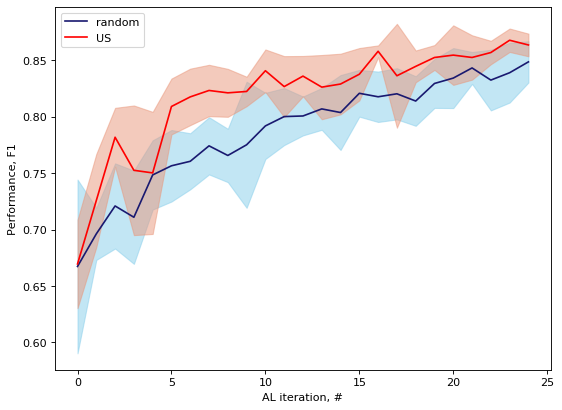

In [56]:
create_chart('../Logs/experimentsa', 'i-org')

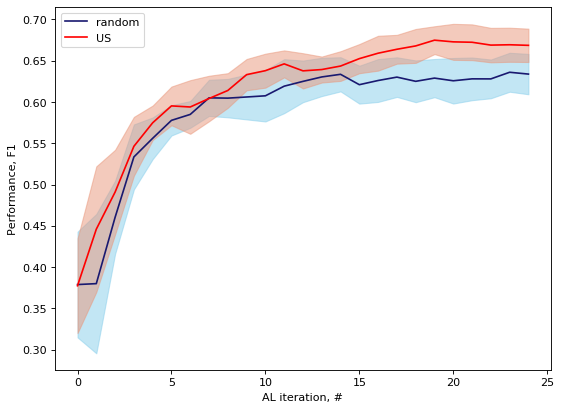

In [19]:
create_chart('../workdir/experiments_2/', 'diabetes')

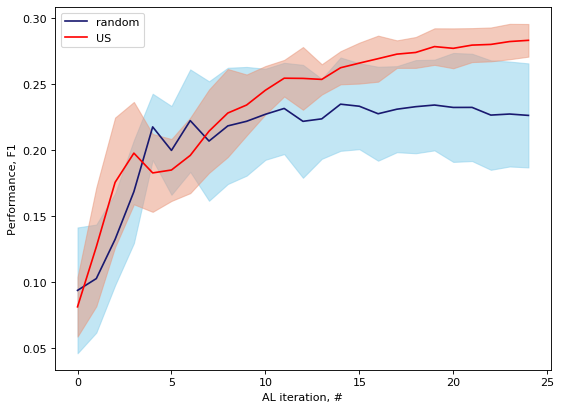

In [20]:
create_chart('../workdir/experiments_2/', 'cad')

In [44]:
def run_experiment_al(train_dataset,
                      test_dataset,
                      attr_name, 
                      word_tokenizer, 
                      bpe_tokenizer,
                      output_file_path,
                      n_passes=10,
                      n_al_iterations=25):
    logger.info('Preparing data...')
    
    train_selected_dataset = drop_noise_samples(train_dataset, attr_name)
    test_selected_dataset = drop_noise_samples(test_dataset, attr_name)
    #train_selected_dataset, test_selected_dataset = split_train_test_by_document(selected_dataset, test_ratio=0.2)
    train_sents, train_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, 
                                                             train_selected_dataset, attr_name, MAX_LEN)
    test_sents, test_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, 
                                                           test_selected_dataset, attr_name, MAX_LEN)
    
    tags_vals = ['B', 'I', 'O', 'X', '[CLS]', '[SEP]']
    tag2idx = {t : i for i, t in enumerate(tags_vals)}
    
    train_input_ids, train_tags, train_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                        train_sents, train_labels, MAX_LEN)
    test_input_ids, test_tags, test_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                     test_sents, test_labels, MAX_LEN)
    
    logger.info('Done.')
    
    #logger.info('Initializing model...')
    
    #model, optimizer, lr_scheduler = create_model_optimizer(tag2idx)
    
    #logger.info('Done.')
    
    logger.info('Preparing active learning...')
    
    logger.info('Done.')
    
    logger.info('=======================Active learning with uncertainty sampling ======================')
    
    ranking_strategy = lambda trn_ds, _libact_model: UncertaintySampling(trn_ds, model=_libact_model, method='lc')
    stats = perform_several_al_passes(train_input_ids, train_tags, test_input_ids, 
                                      test_tags, tags_vals, tag2idx, 
                                      ranking_strategy=ranking_strategy, 
                                      fit_model=False, 
                                      n_passes=n_passes,
                                      n_al_iterations=n_al_iterations)
    stats = np.array([[e['_f1_score'] for e in series] for series in stats ])
    np.save(os.path.join(output_file_path, '{}_us.npy'.format(attr_name.lower())), stats)
    
    logger.info('Done with uncertainty sampling.')
    
    logger.info('=======================Active learning with random sampling ============================')
    
    ranking_strategy = lambda trn_ds, _libact_model: RandomSamplingWithRetraining(trn_ds, model=_libact_model, method='lc')
    stats = perform_several_al_passes(train_input_ids, train_tags, 
                                       test_input_ids, test_tags, 
                                       tags_vals, tag2idx, 
                                       ranking_strategy=ranking_strategy, 
                                       fit_model=False,
                                       n_passes=n_passes,
                                      n_al_iterations=n_al_iterations)
    stats = np.array([[e['_f1_score'] for e in series] for series in stats ])
    np.save(os.path.join(output_file_path, '{}_random.npy'.format(attr_name.lower())), stats)
    logger.info('Done.')

In [ ]:
from isanlp.en.processor_tokenizer_nltk_en import ProcessorTokenizerNltkEn

word_tokenizer = ProcessorTokenizerNltkEn()
bpe_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', cache_dir=CACHE_DIR, do_lower_case=False)
run_experiment_al(dataset, dataset_test, 'Gene_span', word_tokenizer, bpe_tokenizer, 
                  output_file_path='../Logs/experiments_bio/')
#'../Logs/experiments/'

2019-08-13 07:24:03,442 - biomed_ie - INFO - Preparing data...
2019-08-13 07:24:13,907 - biomed_ie - INFO - Done.
2019-08-13 07:24:13,908 - biomed_ie - INFO - Preparing active learning...
2019-08-13 07:24:13,909 - biomed_ie - INFO - Done.
2019-08-13 07:24:13,910 - biomed_ie - INFO - =======================Active learning with uncertainty sampling ======================
2019-08-13 07:24:13,911 - biomed_ie - INFO - =============== Pass: 0 =============
60
2019-08-13 07:24:13,927 - biomed_ie - INFO - Start emulating active learning.
2019-08-13 07:24:19,798 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:24:19,803 - biomed_ie - INFO - N parameters: 108314886



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:24:20,435 - biomed_ie - INFO - Train loss: 0.13055373288568903
2019-08-13 07:24:20,486 - biomed_ie - INFO - Validation loss: 0.13157408501623724



Epoch:   3%|▎         | 1/30 [00:00<00:19,  1.49it/s]

2019-08-13 07:24:21,079 - biomed_ie - INFO - Train loss: 0.06204452976340154
2019-08-13 07:24:21,130 - biomed_ie - INFO - Validation loss: 0.06026606823919865



Epoch:   7%|▋         | 2/30 [00:01<00:18,  1.51it/s]

2019-08-13 07:24:21,748 - biomed_ie - INFO - Train loss: 0.03235357370777209
2019-08-13 07:24:21,799 - biomed_ie - INFO - Validation loss: 0.03941566128215816



Epoch:  10%|█         | 3/30 [00:01<00:17,  1.50it/s]

2019-08-13 07:24:22,394 - biomed_ie - INFO - Train loss: 0.022321503578883704
2019-08-13 07:24:22,445 - biomed_ie - INFO - Validation loss: 0.03226140689047322



Epoch:  13%|█▎        | 4/30 [00:02<00:17,  1.52it/s]

2019-08-13 07:24:23,037 - biomed_ie - INFO - Train loss: 0.01229624508223573
2019-08-13 07:24:23,088 - biomed_ie - INFO - Validation loss: 0.028996656519500605



Epoch:  17%|█▋        | 5/30 [00:03<00:16,  1.53it/s]

2019-08-13 07:24:23,677 - biomed_ie - INFO - Train loss: 0.008902996091446916
2019-08-13 07:24:23,728 - biomed_ie - INFO - Validation loss: 0.03255178726070559



Epoch:  20%|██        | 6/30 [00:03<00:15,  1.54it/s]

2019-08-13 07:24:24,310 - biomed_ie - INFO - Train loss: 0.006310417904655953
2019-08-13 07:24:24,362 - biomed_ie - INFO - Validation loss: 0.0332589236415954



Epoch:  23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]

2019-08-13 07:24:24,952 - biomed_ie - INFO - Train loss: 0.0034526521988884834
2019-08-13 07:24:25,003 - biomed_ie - INFO - Validation loss: 0.0330032004882042


2019-08-13 07:24:30,437 - biomed_ie - INFO - Evaluation: {'_f1_score': 0.4106832525381871}
2019-08-13 07:24:30,439 - biomed_ie - INFO - Active learning iteration: #0
2019-08-13 07:24:36,223 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:24:36,227 - biomed_ie - INFO - N parameters: 108314886



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:24:36,857 - biomed_ie - INFO - Train loss: 0.13539018574411538
2019-08-13 07:24:36,908 - biomed_ie - INFO - Validation loss: 0.11252304103886969



Epoch:   3%|▎         | 1/30 [00:00<00:19,  1.50it/s]

2019-08-13 07:24:37,504 - biomed_ie - INFO - Train loss: 0.06611925861473668
2019-08-13 07:24:37,556 - biomed_ie - INFO - Validation loss: 0.08967348905367271



Epoch:   7%|▋         | 2/30 [00:01<00:18,  1.51it/s]

2019-08-13 07:24:38,155 - biomed_ie - INFO - Train loss: 0.051022770672344175
2019-08-13 07:24:38,207 - biomed_ie - INFO - Validation loss: 0.03924960287931923



Epoch:  10%|█         | 3/30 [00:01<00:17,  1.52it/s]

2019-08-13 07:24:38,800 - biomed_ie - INFO - Train loss: 0.02417331556842519
2019-08-13 07:24:38,852 - biomed_ie - INFO - Validation loss: 0.02881482104274714



Epoch:  13%|█▎        | 4/30 [00:02<00:17,  1.53it/s]

2019-08-13 07:24:39,449 - biomed_ie - INFO - Train loss: 0.015004546378310574
2019-08-13 07:24:39,500 - biomed_ie - INFO - Validation loss: 0.02232316498444459



Epoch:  17%|█▋        | 5/30 [00:03<00:16,  1.53it/s]

2019-08-13 07:24:40,089 - biomed_ie - INFO - Train loss: 0.010076270899558148
2019-08-13 07:24:40,139 - biomed_ie - INFO - Validation loss: 0.021442914863241794



Epoch:  20%|██        | 6/30 [00:03<00:15,  1.54it/s]

2019-08-13 07:24:40,727 - biomed_ie - INFO - Train loss: 0.006421528723472071
2019-08-13 07:24:40,777 - biomed_ie - INFO - Validation loss: 0.02031926054078099



Epoch:  23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]

2019-08-13 07:24:41,381 - biomed_ie - INFO - Train loss: 0.0038637453252822525
2019-08-13 07:24:41,435 - biomed_ie - INFO - Validation loss: 0.0242272362902157



Epoch:  27%|██▋       | 8/30 [00:05<00:14,  1.54it/s]

2019-08-13 07:24:42,032 - biomed_ie - INFO - Train loss: 0.0021259310078455915
2019-08-13 07:24:42,084 - biomed_ie - INFO - Validation loss: 0.031983829175943154



Epoch:  30%|███       | 9/30 [00:05<00:13,  1.54it/s]

2019-08-13 07:24:42,676 - biomed_ie - INFO - Train loss: 0.0013883553861511028
2019-08-13 07:24:42,728 - biomed_ie - INFO - Validation loss: 0.03289654618854463


2019-08-13 07:25:13,322 - biomed_ie - INFO - Performance: {'_f1_score': 0.472632493483927}
2019-08-13 07:25:13,323 - biomed_ie - INFO - Active learning iteration: #1
2019-08-13 07:25:20,120 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:25:20,124 - biomed_ie - INFO - N parameters: 108314886



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:25:20,997 - biomed_ie - INFO - Train loss: 0.11135057581695387
2019-08-13 07:25:21,064 - biomed_ie - INFO - Validation loss: 0.045849970408848355



Epoch:   3%|▎         | 1/30 [00:00<00:26,  1.08it/s]

2019-08-13 07:25:21,908 - biomed_ie - INFO - Train loss: 0.04307848875835465
2019-08-13 07:25:21,974 - biomed_ie - INFO - Validation loss: 0.025012176864001215



Epoch:   7%|▋         | 2/30 [00:01<00:25,  1.09it/s]

2019-08-13 07:25:22,809 - biomed_ie - INFO - Train loss: 0.02233945537799661
2019-08-13 07:25:22,874 - biomed_ie - INFO - Validation loss: 0.020383147560820287



Epoch:  10%|█         | 3/30 [00:02<00:24,  1.09it/s]

2019-08-13 07:25:23,710 - biomed_ie - INFO - Train loss: 0.01525432348320711
2019-08-13 07:25:23,776 - biomed_ie - INFO - Validation loss: 0.01375457948567916



Epoch:  13%|█▎        | 4/30 [00:03<00:23,  1.10it/s]

2019-08-13 07:25:24,605 - biomed_ie - INFO - Train loss: 0.011228715390149057
2019-08-13 07:25:24,671 - biomed_ie - INFO - Validation loss: 0.014481627211278799



Epoch:  17%|█▋        | 5/30 [00:04<00:22,  1.10it/s]

2019-08-13 07:25:25,505 - biomed_ie - INFO - Train loss: 0.007459698941321231
2019-08-13 07:25:25,570 - biomed_ie - INFO - Validation loss: 0.0169029138526138



Epoch:  20%|██        | 6/30 [00:05<00:21,  1.11it/s]

2019-08-13 07:25:26,401 - biomed_ie - INFO - Train loss: 0.004891260530596942
2019-08-13 07:25:26,468 - biomed_ie - INFO - Validation loss: 0.01650298614891208
2019-08-13 07:25:57,039 - biomed_ie - INFO - Performance: {'_f1_score': 0.4936754607878569}
2019-08-13 07:25:57,040 - biomed_ie - INFO - Active learning iteration: #2
2019-08-13 07:26:02,810 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:26:02,814 - biomed_ie - INFO - N parameters: 108314886




Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:26:03,803 - biomed_ie - INFO - Train loss: 0.08504210446498477
2019-08-13 07:26:03,886 - biomed_ie - INFO - Validation loss: 0.07738736873501344




Epoch:   3%|▎         | 1/30 [00:01<00:30,  1.05s/it]

2019-08-13 07:26:04,859 - biomed_ie - INFO - Train loss: 0.05519439445802137
2019-08-13 07:26:04,941 - biomed_ie - INFO - Validation loss: 0.030243396759033203




Epoch:   7%|▋         | 2/30 [00:02<00:29,  1.05s/it]

2019-08-13 07:26:05,916 - biomed_ie - INFO - Train loss: 0.028661607059353222
2019-08-13 07:26:05,997 - biomed_ie - INFO - Validation loss: 0.02122423983235874




Epoch:  10%|█         | 3/30 [00:03<00:28,  1.05s/it]

2019-08-13 07:26:06,933 - biomed_ie - INFO - Train loss: 0.019490269369821994
2019-08-13 07:26:07,014 - biomed_ie - INFO - Validation loss: 0.015765052516135813




Epoch:  13%|█▎        | 4/30 [00:04<00:27,  1.04s/it]

2019-08-13 07:26:07,948 - biomed_ie - INFO - Train loss: 0.012404381530876476
2019-08-13 07:26:08,029 - biomed_ie - INFO - Validation loss: 0.013342986819050122




Epoch:  17%|█▋        | 5/30 [00:05<00:25,  1.03s/it]

2019-08-13 07:26:08,966 - biomed_ie - INFO - Train loss: 0.008529302220909663
2019-08-13 07:26:09,048 - biomed_ie - INFO - Validation loss: 0.01444943301694494




Epoch:  20%|██        | 6/30 [00:06<00:24,  1.03s/it]

2019-08-13 07:26:09,984 - biomed_ie - INFO - Train loss: 0.004984904588315792
2019-08-13 07:26:10,065 - biomed_ie - INFO - Validation loss: 0.01751822485050685




Epoch:  23%|██▎       | 7/30 [00:07<00:23,  1.03s/it]

2019-08-13 07:26:11,052 - biomed_ie - INFO - Train loss: 0.0025937121978991205
2019-08-13 07:26:11,136 - biomed_ie - INFO - Validation loss: 0.022315973757018506
2019-08-13 07:26:41,695 - biomed_ie - INFO - Performance: {'_f1_score': 0.36150877629777173}
2019-08-13 07:26:41,696 - biomed_ie - INFO - Active learning iteration: #3
2019-08-13 07:26:47,494 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:26:47,498 - biomed_ie - INFO - N parameters: 108314886





Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:26:48,725 - biomed_ie - INFO - Train loss: 0.0834630756395791
2019-08-13 07:26:48,822 - biomed_ie - INFO - Validation loss: 0.029088499267840594





Epoch:   3%|▎         | 1/30 [00:01<00:37,  1.30s/it]

2019-08-13 07:26:49,987 - biomed_ie - INFO - Train loss: 0.03827835933254857
2019-08-13 07:26:50,085 - biomed_ie - INFO - Validation loss: 0.023169063901081022





Epoch:   7%|▋         | 2/30 [00:02<00:36,  1.29s/it]

2019-08-13 07:26:51,242 - biomed_ie - INFO - Train loss: 0.022496102295192003
2019-08-13 07:26:51,339 - biomed_ie - INFO - Validation loss: 0.013592269796374122





Epoch:  10%|█         | 3/30 [00:03<00:34,  1.28s/it]

2019-08-13 07:26:52,489 - biomed_ie - INFO - Train loss: 0.01462352865838946
2019-08-13 07:26:52,586 - biomed_ie - INFO - Validation loss: 0.013294717645933327





Epoch:  13%|█▎        | 4/30 [00:05<00:33,  1.27s/it]

2019-08-13 07:26:53,738 - biomed_ie - INFO - Train loss: 0.010571684206611124
2019-08-13 07:26:53,836 - biomed_ie - INFO - Validation loss: 0.014373351118831732





Epoch:  17%|█▋        | 5/30 [00:06<00:31,  1.26s/it]

2019-08-13 07:26:54,996 - biomed_ie - INFO - Train loss: 0.007852747476673479
2019-08-13 07:26:55,093 - biomed_ie - INFO - Validation loss: 0.013862350052426106





Epoch:  20%|██        | 6/30 [00:07<00:30,  1.26s/it]

2019-08-13 07:26:56,248 - biomed_ie - INFO - Train loss: 0.004688843114420845
2019-08-13 07:26:56,346 - biomed_ie - INFO - Validation loss: 0.01599178071467614
2019-08-13 07:27:26,830 - biomed_ie - INFO - Performance: {'_f1_score': 0.4326396495071194}
2019-08-13 07:27:26,831 - biomed_ie - INFO - Active learning iteration: #4
2019-08-13 07:27:32,693 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:27:32,697 - biomed_ie - INFO - N parameters: 108314886






Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:27:34,117 - biomed_ie - INFO - Train loss: 0.06567121548094872
2019-08-13 07:27:34,225 - biomed_ie - INFO - Validation loss: 0.030677711009441666






Epoch:   3%|▎         | 1/30 [00:01<00:43,  1.51s/it]

2019-08-13 07:27:35,615 - biomed_ie - INFO - Train loss: 0.0291154999906116
2019-08-13 07:27:35,722 - biomed_ie - INFO - Validation loss: 0.014306884293984487






Epoch:   7%|▋         | 2/30 [00:03<00:42,  1.50s/it]

2019-08-13 07:27:37,109 - biomed_ie - INFO - Train loss: 0.018194488566010754
2019-08-13 07:27:37,216 - biomed_ie - INFO - Validation loss: 0.010546515508506228






Epoch:  10%|█         | 3/30 [00:04<00:40,  1.50s/it]

2019-08-13 07:27:38,639 - biomed_ie - INFO - Train loss: 0.012187781529684794
2019-08-13 07:27:38,745 - biomed_ie - INFO - Validation loss: 0.01063186035528975






Epoch:  13%|█▎        | 4/30 [00:06<00:39,  1.51s/it]

2019-08-13 07:27:40,170 - biomed_ie - INFO - Train loss: 0.008966186613814289
2019-08-13 07:27:40,277 - biomed_ie - INFO - Validation loss: 0.01177620793679118






Epoch:  17%|█▋        | 5/30 [00:07<00:37,  1.52s/it]

2019-08-13 07:27:41,689 - biomed_ie - INFO - Train loss: 0.006572557616764044
2019-08-13 07:27:41,796 - biomed_ie - INFO - Validation loss: 0.012574616745422316
2019-08-13 07:28:12,407 - biomed_ie - INFO - Performance: {'_f1_score': 0.4786455674663944}
2019-08-13 07:28:12,408 - biomed_ie - INFO - Active learning iteration: #5
2019-08-13 07:28:18,185 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:28:18,189 - biomed_ie - INFO - N parameters: 108314886







Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:28:19,796 - biomed_ie - INFO - Train loss: 0.057370683034261065
2019-08-13 07:28:19,921 - biomed_ie - INFO - Validation loss: 0.016922364457359937







Epoch:   3%|▎         | 1/30 [00:01<00:49,  1.71s/it]

2019-08-13 07:28:21,444 - biomed_ie - INFO - Train loss: 0.02375527795155843
2019-08-13 07:28:21,568 - biomed_ie - INFO - Validation loss: 0.009680366972769194







Epoch:   7%|▋         | 2/30 [00:03<00:47,  1.69s/it]

2019-08-13 07:28:23,074 - biomed_ie - INFO - Train loss: 0.014505427837371826
2019-08-13 07:28:23,200 - biomed_ie - INFO - Validation loss: 0.008071792836464737







Epoch:  10%|█         | 3/30 [00:04<00:45,  1.67s/it]

2019-08-13 07:28:24,751 - biomed_ie - INFO - Train loss: 0.009570871194203695
2019-08-13 07:28:24,877 - biomed_ie - INFO - Validation loss: 0.008598534384000657







Epoch:  13%|█▎        | 4/30 [00:06<00:43,  1.67s/it]

2019-08-13 07:28:26,440 - biomed_ie - INFO - Train loss: 0.006050043900807699
2019-08-13 07:28:26,564 - biomed_ie - INFO - Validation loss: 0.00759403500101763







Epoch:  17%|█▋        | 5/30 [00:08<00:41,  1.68s/it]

2019-08-13 07:28:28,070 - biomed_ie - INFO - Train loss: 0.004150075395901998
2019-08-13 07:28:28,195 - biomed_ie - INFO - Validation loss: 0.008554454198913292







Epoch:  20%|██        | 6/30 [00:09<00:39,  1.66s/it]

2019-08-13 07:28:29,707 - biomed_ie - INFO - Train loss: 0.0034970692396163942
2019-08-13 07:28:29,832 - biomed_ie - INFO - Validation loss: 0.012591384537690651







Epoch:  23%|██▎       | 7/30 [00:11<00:38,  1.66s/it]

2019-08-13 07:28:31,344 - biomed_ie - INFO - Train loss: 0.0024412251512209576
2019-08-13 07:28:31,469 - biomed_ie - INFO - Validation loss: 0.010895001729918662
2019-08-13 07:29:01,836 - biomed_ie - INFO - Performance: {'_f1_score': 0.5414206817749}
2019-08-13 07:29:01,837 - biomed_ie - INFO - Active learning iteration: #6
2019-08-13 07:29:07,626 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:29:07,630 - biomed_ie - INFO - N parameters: 108314886








Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:29:09,412 - biomed_ie - INFO - Train loss: 0.06584597498496503
2019-08-13 07:29:09,571 - biomed_ie - INFO - Validation loss: 0.014078404222215925








Epoch:   3%|▎         | 1/30 [00:01<00:55,  1.91s/it]

2019-08-13 07:29:11,318 - biomed_ie - INFO - Train loss: 0.02280818007052279
2019-08-13 07:29:11,458 - biomed_ie - INFO - Validation loss: 0.010326609040706727








Epoch:   7%|▋         | 2/30 [00:03<00:53,  1.91s/it]

2019-08-13 07:29:13,258 - biomed_ie - INFO - Train loss: 0.015527593855574109
2019-08-13 07:29:13,398 - biomed_ie - INFO - Validation loss: 0.0061670466542311266








Epoch:  10%|█         | 3/30 [00:05<00:51,  1.92s/it]

2019-08-13 07:29:15,224 - biomed_ie - INFO - Train loss: 0.011351946077676249
2019-08-13 07:29:15,363 - biomed_ie - INFO - Validation loss: 0.012829877911550993








Epoch:  13%|█▎        | 4/30 [00:07<00:50,  1.93s/it]

2019-08-13 07:29:17,180 - biomed_ie - INFO - Train loss: 0.01248216317475737
2019-08-13 07:29:17,319 - biomed_ie - INFO - Validation loss: 0.005948662185722794








Epoch:  17%|█▋        | 5/30 [00:09<00:48,  1.94s/it]

2019-08-13 07:29:19,128 - biomed_ie - INFO - Train loss: 0.00711954155824654
2019-08-13 07:29:19,268 - biomed_ie - INFO - Validation loss: 0.007611184151141675








Epoch:  20%|██        | 6/30 [00:11<00:46,  1.94s/it]

2019-08-13 07:29:20,999 - biomed_ie - INFO - Train loss: 0.005048931421175381
2019-08-13 07:29:21,139 - biomed_ie - INFO - Validation loss: 0.007797101168629815








Epoch:  23%|██▎       | 7/30 [00:13<00:44,  1.92s/it]

2019-08-13 07:29:22,869 - biomed_ie - INFO - Train loss: 0.0028533818256490633
2019-08-13 07:29:23,009 - biomed_ie - INFO - Validation loss: 0.010006251744400101
2019-08-13 07:29:53,314 - biomed_ie - INFO - Performance: {'_f1_score': 0.5016770918321095}
2019-08-13 07:29:53,315 - biomed_ie - INFO - Active learning iteration: #7
2019-08-13 07:29:59,125 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:29:59,129 - biomed_ie - INFO - N parameters: 108314886









Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:30:01,108 - biomed_ie - INFO - Train loss: 0.057879293716194796
2019-08-13 07:30:01,264 - biomed_ie - INFO - Validation loss: 0.015383912332402834









Epoch:   3%|▎         | 1/30 [00:02<01:01,  2.11s/it]

2019-08-13 07:30:03,186 - biomed_ie - INFO - Train loss: 0.020380278830012297
2019-08-13 07:30:03,343 - biomed_ie - INFO - Validation loss: 0.007647533086860704









Epoch:   7%|▋         | 2/30 [00:04<00:58,  2.10s/it]

2019-08-13 07:30:05,289 - biomed_ie - INFO - Train loss: 0.012012427282201076
2019-08-13 07:30:05,444 - biomed_ie - INFO - Validation loss: 0.0065173757900981785









Epoch:  10%|█         | 3/30 [00:06<00:56,  2.10s/it]

2019-08-13 07:30:07,382 - biomed_ie - INFO - Train loss: 0.008319821969129431
2019-08-13 07:30:07,537 - biomed_ie - INFO - Validation loss: 0.006468864356946645









Epoch:  13%|█▎        | 4/30 [00:08<00:54,  2.10s/it]

2019-08-13 07:30:09,461 - biomed_ie - INFO - Train loss: 0.00533893722132752
2019-08-13 07:30:09,616 - biomed_ie - INFO - Validation loss: 0.008363717007187178









Epoch:  17%|█▋        | 5/30 [00:10<00:52,  2.09s/it]

2019-08-13 07:30:11,477 - biomed_ie - INFO - Train loss: 0.0033414921399576533
2019-08-13 07:30:11,633 - biomed_ie - INFO - Validation loss: 0.007613436980817303









Epoch:  20%|██        | 6/30 [00:12<00:49,  2.07s/it]

2019-08-13 07:30:13,555 - biomed_ie - INFO - Train loss: 0.0019648471227771366
2019-08-13 07:30:13,710 - biomed_ie - INFO - Validation loss: 0.010790911110692053
2019-08-13 07:30:44,013 - biomed_ie - INFO - Performance: {'_f1_score': 0.5311489095272879}
2019-08-13 07:30:44,014 - biomed_ie - INFO - Active learning iteration: #8
2019-08-13 07:30:49,832 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:30:49,836 - biomed_ie - INFO - N parameters: 108314886










Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:30:52,041 - biomed_ie - INFO - Train loss: 0.046063609119188414
2019-08-13 07:30:52,215 - biomed_ie - INFO - Validation loss: 0.007608814993544786










Epoch:   3%|▎         | 1/30 [00:02<01:08,  2.35s/it]

2019-08-13 07:30:54,369 - biomed_ie - INFO - Train loss: 0.016285098909169776
2019-08-13 07:30:54,541 - biomed_ie - INFO - Validation loss: 0.006482737463082062










Epoch:   7%|▋         | 2/30 [00:04<01:05,  2.34s/it]

2019-08-13 07:30:56,705 - biomed_ie - INFO - Train loss: 0.011336252878473074
2019-08-13 07:30:56,879 - biomed_ie - INFO - Validation loss: 0.005760070813800694










Epoch:  10%|█         | 3/30 [00:07<01:03,  2.34s/it]

2019-08-13 07:30:59,050 - biomed_ie - INFO - Train loss: 0.00833692014646793
2019-08-13 07:30:59,224 - biomed_ie - INFO - Validation loss: 0.005011776540602162










Epoch:  13%|█▎        | 4/30 [00:09<01:00,  2.34s/it]

2019-08-13 07:31:01,371 - biomed_ie - INFO - Train loss: 0.004685101055765509
2019-08-13 07:31:01,544 - biomed_ie - INFO - Validation loss: 0.005675673959469497










Epoch:  17%|█▋        | 5/30 [00:11<00:58,  2.34s/it]

2019-08-13 07:31:03,692 - biomed_ie - INFO - Train loss: 0.002753985133998255
2019-08-13 07:31:03,865 - biomed_ie - INFO - Validation loss: 0.006409805518097167










Epoch:  20%|██        | 6/30 [00:14<00:55,  2.33s/it]

2019-08-13 07:31:06,020 - biomed_ie - INFO - Train loss: 0.0018896517278170042
2019-08-13 07:31:06,193 - biomed_ie - INFO - Validation loss: 0.0073618700344272306
2019-08-13 07:31:36,495 - biomed_ie - INFO - Performance: {'_f1_score': 0.5690534668430001}
2019-08-13 07:31:36,496 - biomed_ie - INFO - Active learning iteration: #9
2019-08-13 07:31:42,298 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:31:42,302 - biomed_ie - INFO - N parameters: 108314886











Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:31:44,746 - biomed_ie - INFO - Train loss: 0.045403456681835826
2019-08-13 07:31:44,936 - biomed_ie - INFO - Validation loss: 0.008809351612528328











Epoch:   3%|▎         | 1/30 [00:02<01:15,  2.60s/it]

2019-08-13 07:31:47,323 - biomed_ie - INFO - Train loss: 0.017090204781455294
2019-08-13 07:31:47,512 - biomed_ie - INFO - Validation loss: 0.006476996639466422











Epoch:   7%|▋         | 2/30 [00:05<01:12,  2.60s/it]

2019-08-13 07:31:49,898 - biomed_ie - INFO - Train loss: 0.013327497967999995
2019-08-13 07:31:50,088 - biomed_ie - INFO - Validation loss: 0.0064930622217198725











Epoch:  10%|█         | 3/30 [00:07<01:09,  2.59s/it]

2019-08-13 07:31:52,471 - biomed_ie - INFO - Train loss: 0.011487950951119864
2019-08-13 07:31:52,660 - biomed_ie - INFO - Validation loss: 0.005856935690932324











Epoch:  13%|█▎        | 4/30 [00:10<01:07,  2.58s/it]

2019-08-13 07:31:55,037 - biomed_ie - INFO - Train loss: 0.007994748379770565
2019-08-13 07:31:55,227 - biomed_ie - INFO - Validation loss: 0.004797065806565171











Epoch:  17%|█▋        | 5/30 [00:12<01:04,  2.58s/it]

2019-08-13 07:31:57,600 - biomed_ie - INFO - Train loss: 0.004673824375747538
2019-08-13 07:31:57,790 - biomed_ie - INFO - Validation loss: 0.006230025504001752











Epoch:  20%|██        | 6/30 [00:15<01:01,  2.57s/it]

2019-08-13 07:32:00,174 - biomed_ie - INFO - Train loss: 0.003499021600431244
2019-08-13 07:32:00,364 - biomed_ie - INFO - Validation loss: 0.007828228304203945











Epoch:  23%|██▎       | 7/30 [00:18<00:59,  2.57s/it]

2019-08-13 07:32:02,749 - biomed_ie - INFO - Train loss: 0.002305295249836507
2019-08-13 07:32:02,939 - biomed_ie - INFO - Validation loss: 0.008898568182767368
2019-08-13 07:32:33,098 - biomed_ie - INFO - Performance: {'_f1_score': 0.5525395846185482}
2019-08-13 07:32:33,099 - biomed_ie - INFO - Active learning iteration: #10
2019-08-13 07:32:38,913 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:32:38,917 - biomed_ie - INFO - N parameters: 108314886












Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:32:41,516 - biomed_ie - INFO - Train loss: 0.045103912702626044
2019-08-13 07:32:41,720 - biomed_ie - INFO - Validation loss: 0.00677989465362453












Epoch:   3%|▎         | 1/30 [00:02<01:20,  2.77s/it]

2019-08-13 07:32:44,259 - biomed_ie - INFO - Train loss: 0.014638675464948674
2019-08-13 07:32:44,464 - biomed_ie - INFO - Validation loss: 0.00500440795592811












Epoch:   7%|▋         | 2/30 [00:05<01:17,  2.76s/it]

2019-08-13 07:32:46,993 - biomed_ie - INFO - Train loss: 0.010038984238978732
2019-08-13 07:32:47,196 - biomed_ie - INFO - Validation loss: 0.0043684463670866855












Epoch:  10%|█         | 3/30 [00:08<01:14,  2.75s/it]

2019-08-13 07:32:49,717 - biomed_ie - INFO - Train loss: 0.006997111754289833
2019-08-13 07:32:49,920 - biomed_ie - INFO - Validation loss: 0.0055396806628188675












Epoch:  13%|█▎        | 4/30 [00:10<01:11,  2.74s/it]

2019-08-13 07:32:52,430 - biomed_ie - INFO - Train loss: 0.004419271068270155
2019-08-13 07:32:52,632 - biomed_ie - INFO - Validation loss: 0.005243655080304103












Epoch:  17%|█▋        | 5/30 [00:13<01:08,  2.73s/it]

2019-08-13 07:32:55,141 - biomed_ie - INFO - Train loss: 0.0028784728618062127
2019-08-13 07:32:55,344 - biomed_ie - INFO - Validation loss: 0.006113942861777072
2019-08-13 07:33:25,417 - biomed_ie - INFO - Performance: {'_f1_score': 0.5595001983339946}
2019-08-13 07:33:25,419 - biomed_ie - INFO - Active learning iteration: #11
2019-08-13 07:33:31,242 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:33:31,246 - biomed_ie - INFO - N parameters: 108314886













Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:33:34,063 - biomed_ie - INFO - Train loss: 0.037587035560618376
2019-08-13 07:33:34,279 - biomed_ie - INFO - Validation loss: 0.0050275392046229585













Epoch:   3%|▎         | 1/30 [00:02<01:26,  3.00s/it]

2019-08-13 07:33:37,048 - biomed_ie - INFO - Train loss: 0.014750220003380315
2019-08-13 07:33:37,264 - biomed_ie - INFO - Validation loss: 0.004245906193159626













Epoch:   7%|▋         | 2/30 [00:05<01:23,  2.99s/it]

2019-08-13 07:33:40,009 - biomed_ie - INFO - Train loss: 0.011272363478364673
2019-08-13 07:33:40,227 - biomed_ie - INFO - Validation loss: 0.00396114136471838













Epoch:  10%|█         | 3/30 [00:08<01:20,  2.98s/it]

2019-08-13 07:33:43,012 - biomed_ie - INFO - Train loss: 0.0066008420025081595
2019-08-13 07:33:43,229 - biomed_ie - INFO - Validation loss: 0.004390216392874522













Epoch:  13%|█▎        | 4/30 [00:11<01:17,  2.99s/it]

2019-08-13 07:33:46,016 - biomed_ie - INFO - Train loss: 0.0043354154077977275
2019-08-13 07:33:46,233 - biomed_ie - INFO - Validation loss: 0.0045887444995488715













Epoch:  17%|█▋        | 5/30 [00:14<01:14,  2.99s/it]

2019-08-13 07:33:48,991 - biomed_ie - INFO - Train loss: 0.002490652633307336
2019-08-13 07:33:49,209 - biomed_ie - INFO - Validation loss: 0.006413608740281445
2019-08-13 07:34:19,234 - biomed_ie - INFO - Performance: {'_f1_score': 0.568920282542886}
2019-08-13 07:34:19,235 - biomed_ie - INFO - Active learning iteration: #12
2019-08-13 07:34:24,985 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:34:24,990 - biomed_ie - INFO - N parameters: 108314886














Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:34:27,950 - biomed_ie - INFO - Train loss: 0.046763443311644094
2019-08-13 07:34:28,183 - biomed_ie - INFO - Validation loss: 0.005684813850351166














Epoch:   3%|▎         | 1/30 [00:03<01:31,  3.16s/it]

2019-08-13 07:34:30,986 - biomed_ie - INFO - Train loss: 0.016512239824834688
2019-08-13 07:34:31,218 - biomed_ie - INFO - Validation loss: 0.004821520178187063














Epoch:   7%|▋         | 2/30 [00:06<01:27,  3.12s/it]

2019-08-13 07:34:34,017 - biomed_ie - INFO - Train loss: 0.012058614902778864
2019-08-13 07:34:34,251 - biomed_ie - INFO - Validation loss: 0.0036913021961668545














Epoch:  10%|█         | 3/30 [00:09<01:23,  3.09s/it]

2019-08-13 07:34:37,044 - biomed_ie - INFO - Train loss: 0.008028497336878672
2019-08-13 07:34:37,277 - biomed_ie - INFO - Validation loss: 0.0037469345434345274














Epoch:  13%|█▎        | 4/30 [00:12<01:19,  3.07s/it]

2019-08-13 07:34:40,071 - biomed_ie - INFO - Train loss: 0.005094631368263032
2019-08-13 07:34:40,304 - biomed_ie - INFO - Validation loss: 0.004056675529192946














Epoch:  17%|█▋        | 5/30 [00:15<01:16,  3.06s/it]

2019-08-13 07:34:43,094 - biomed_ie - INFO - Train loss: 0.0028613124577123454
2019-08-13 07:34:43,328 - biomed_ie - INFO - Validation loss: 0.004571394601022506
2019-08-13 07:35:13,250 - biomed_ie - INFO - Performance: {'_f1_score': 0.5746753246753247}
2019-08-13 07:35:13,251 - biomed_ie - INFO - Active learning iteration: #13
2019-08-13 07:35:19,047 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:35:19,051 - biomed_ie - INFO - N parameters: 108314886















Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:35:22,120 - biomed_ie - INFO - Train loss: 0.0535429779857293
2019-08-13 07:35:22,368 - biomed_ie - INFO - Validation loss: 0.006878680347610907















Epoch:   3%|▎         | 1/30 [00:03<01:35,  3.28s/it]

2019-08-13 07:35:25,382 - biomed_ie - INFO - Train loss: 0.015728676479345255
2019-08-13 07:35:25,629 - biomed_ie - INFO - Validation loss: 0.003914281072810536















Epoch:   7%|▋         | 2/30 [00:06<01:31,  3.27s/it]

2019-08-13 07:35:28,643 - biomed_ie - INFO - Train loss: 0.010392965440024386
2019-08-13 07:35:28,891 - biomed_ie - INFO - Validation loss: 0.003738142603347241















Epoch:  10%|█         | 3/30 [00:09<01:28,  3.27s/it]

2019-08-13 07:35:31,899 - biomed_ie - INFO - Train loss: 0.006543912398693705
2019-08-13 07:35:32,146 - biomed_ie - INFO - Validation loss: 0.004040504280457487















Epoch:  13%|█▎        | 4/30 [00:13<01:24,  3.27s/it]

2019-08-13 07:35:35,161 - biomed_ie - INFO - Train loss: 0.004342525089842497
2019-08-13 07:35:35,411 - biomed_ie - INFO - Validation loss: 0.004529488168654692















Epoch:  17%|█▋        | 5/30 [00:16<01:21,  3.27s/it]

2019-08-13 07:35:38,421 - biomed_ie - INFO - Train loss: 0.00266152102940849
2019-08-13 07:35:38,669 - biomed_ie - INFO - Validation loss: 0.0048838429893541735
2019-08-13 07:36:08,718 - biomed_ie - INFO - Performance: {'_f1_score': 0.5706371191135734}
2019-08-13 07:36:08,720 - biomed_ie - INFO - Active learning iteration: #14
2019-08-13 07:36:14,451 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:36:14,455 - biomed_ie - INFO - N parameters: 108314886
















Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:36:17,752 - biomed_ie - INFO - Train loss: 0.03456030802161761
2019-08-13 07:36:18,018 - biomed_ie - INFO - Validation loss: 0.004280898241158856
















Epoch:   3%|▎         | 1/30 [00:03<01:42,  3.52s/it]

2019-08-13 07:36:21,258 - biomed_ie - INFO - Train loss: 0.014521899553963808
2019-08-13 07:36:21,522 - biomed_ie - INFO - Validation loss: 0.004693364199737702
















Epoch:   7%|▋         | 2/30 [00:07<01:38,  3.52s/it]

2019-08-13 07:36:24,878 - biomed_ie - INFO - Train loss: 0.011889125868275324
2019-08-13 07:36:25,141 - biomed_ie - INFO - Validation loss: 0.002876387377364105
















Epoch:  10%|█         | 3/30 [00:10<01:35,  3.55s/it]

2019-08-13 07:36:28,506 - biomed_ie - INFO - Train loss: 0.007373916291605489
2019-08-13 07:36:28,769 - biomed_ie - INFO - Validation loss: 0.0029957522740580184
















Epoch:  13%|█▎        | 4/30 [00:14<01:32,  3.57s/it]

2019-08-13 07:36:32,114 - biomed_ie - INFO - Train loss: 0.004713650361562308
2019-08-13 07:36:32,377 - biomed_ie - INFO - Validation loss: 0.003288061674728717
















Epoch:  17%|█▋        | 5/30 [00:17<01:29,  3.58s/it]

2019-08-13 07:36:35,721 - biomed_ie - INFO - Train loss: 0.002683533342353527
2019-08-13 07:36:35,985 - biomed_ie - INFO - Validation loss: 0.004040427148547502
2019-08-13 07:37:05,772 - biomed_ie - INFO - Performance: {'_f1_score': 0.5543873440110051}
2019-08-13 07:37:05,773 - biomed_ie - INFO - Active learning iteration: #15
2019-08-13 07:37:11,477 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:37:11,481 - biomed_ie - INFO - N parameters: 108314886

















Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:37:15,060 - biomed_ie - INFO - Train loss: 0.037666256235705194
2019-08-13 07:37:15,343 - biomed_ie - INFO - Validation loss: 0.003981185180169565

















Epoch:   3%|▎         | 1/30 [00:03<01:50,  3.82s/it]

2019-08-13 07:37:18,710 - biomed_ie - INFO - Train loss: 0.013435622729679256
2019-08-13 07:37:18,991 - biomed_ie - INFO - Validation loss: 0.0032279888788859052

















Epoch:   7%|▋         | 2/30 [00:07<01:45,  3.77s/it]

2019-08-13 07:37:22,360 - biomed_ie - INFO - Train loss: 0.009032549323494636
2019-08-13 07:37:22,639 - biomed_ie - INFO - Validation loss: 0.0033807257811228437

















Epoch:  10%|█         | 3/30 [00:11<01:40,  3.73s/it]

2019-08-13 07:37:26,002 - biomed_ie - INFO - Train loss: 0.005944806145604495
2019-08-13 07:37:26,282 - biomed_ie - INFO - Validation loss: 0.0034679196499012134

















Epoch:  13%|█▎        | 4/30 [00:14<01:36,  3.71s/it]

2019-08-13 07:37:29,639 - biomed_ie - INFO - Train loss: 0.0037945918493704415
2019-08-13 07:37:29,918 - biomed_ie - INFO - Validation loss: 0.004630695522567373
2019-08-13 07:37:59,696 - biomed_ie - INFO - Performance: {'_f1_score': 0.5844713971922452}
2019-08-13 07:37:59,697 - biomed_ie - INFO - Active learning iteration: #16
2019-08-13 07:38:05,447 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:38:05,451 - biomed_ie - INFO - N parameters: 108314886


















Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:38:09,118 - biomed_ie - INFO - Train loss: 0.03729008421929014
2019-08-13 07:38:09,413 - biomed_ie - INFO - Validation loss: 0.004748687513327713


















Epoch:   3%|▎         | 1/30 [00:03<01:53,  3.92s/it]

2019-08-13 07:38:13,004 - biomed_ie - INFO - Train loss: 0.014429936720828339
2019-08-13 07:38:13,301 - biomed_ie - INFO - Validation loss: 0.0027536118040826026


















Epoch:   7%|▋         | 2/30 [00:07<01:49,  3.91s/it]

2019-08-13 07:38:16,890 - biomed_ie - INFO - Train loss: 0.010570343642750194
2019-08-13 07:38:17,186 - biomed_ie - INFO - Validation loss: 0.002505136638868764


















Epoch:  10%|█         | 3/30 [00:11<01:45,  3.90s/it]

2019-08-13 07:38:20,776 - biomed_ie - INFO - Train loss: 0.007515912709565163
2019-08-13 07:38:21,071 - biomed_ie - INFO - Validation loss: 0.0023201199746040865


















Epoch:  13%|█▎        | 4/30 [00:15<01:41,  3.90s/it]

2019-08-13 07:38:24,660 - biomed_ie - INFO - Train loss: 0.004725111698790186
2019-08-13 07:38:24,956 - biomed_ie - INFO - Validation loss: 0.0040792353650386855


















Epoch:  17%|█▋        | 5/30 [00:19<01:37,  3.89s/it]

2019-08-13 07:38:28,552 - biomed_ie - INFO - Train loss: 0.003261617583080104
2019-08-13 07:38:28,850 - biomed_ie - INFO - Validation loss: 0.003066166000187669


















Epoch:  20%|██        | 6/30 [00:23<01:33,  3.89s/it]

2019-08-13 07:38:32,438 - biomed_ie - INFO - Train loss: 0.0019750105250889516
2019-08-13 07:38:32,734 - biomed_ie - INFO - Validation loss: 0.0036002046032071714
2019-08-13 07:39:02,423 - biomed_ie - INFO - Performance: {'_f1_score': 0.5923460898502495}
2019-08-13 07:39:02,424 - biomed_ie - INFO - Active learning iteration: #17
2019-08-13 07:39:08,128 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:39:08,133 - biomed_ie - INFO - N parameters: 108314886



















Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:39:11,932 - biomed_ie - INFO - Train loss: 0.035091997223872726
2019-08-13 07:39:12,241 - biomed_ie - INFO - Validation loss: 0.0034831243618016466



















Epoch:   3%|▎         | 1/30 [00:04<01:57,  4.06s/it]

2019-08-13 07:39:15,967 - biomed_ie - INFO - Train loss: 0.012204263818822884
2019-08-13 07:39:16,279 - biomed_ie - INFO - Validation loss: 0.002936865729838698



















Epoch:   7%|▋         | 2/30 [00:08<01:53,  4.05s/it]

2019-08-13 07:39:20,011 - biomed_ie - INFO - Train loss: 0.009409524019942661
2019-08-13 07:39:20,321 - biomed_ie - INFO - Validation loss: 0.0023324608419941738



















Epoch:  10%|█         | 3/30 [00:12<01:49,  4.05s/it]

2019-08-13 07:39:24,051 - biomed_ie - INFO - Train loss: 0.0058655460476604
2019-08-13 07:39:24,361 - biomed_ie - INFO - Validation loss: 0.0024204535547839314



















Epoch:  13%|█▎        | 4/30 [00:16<01:45,  4.05s/it]

2019-08-13 07:39:28,087 - biomed_ie - INFO - Train loss: 0.003583024678000947
2019-08-13 07:39:28,398 - biomed_ie - INFO - Validation loss: 0.0025580991983442055



















Epoch:  17%|█▋        | 5/30 [00:20<01:41,  4.04s/it]

2019-08-13 07:39:32,124 - biomed_ie - INFO - Train loss: 0.0022590562515836837
2019-08-13 07:39:32,434 - biomed_ie - INFO - Validation loss: 0.0032869614842418143
2019-08-13 07:40:02,194 - biomed_ie - INFO - Performance: {'_f1_score': 0.5952338923212709}
2019-08-13 07:40:02,195 - biomed_ie - INFO - Active learning iteration: #18
2019-08-13 07:40:07,895 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:40:07,900 - biomed_ie - INFO - N parameters: 108314886




















Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:40:11,914 - biomed_ie - INFO - Train loss: 0.036274459471703976
2019-08-13 07:40:12,238 - biomed_ie - INFO - Validation loss: 0.0033631322812747275




















Epoch:   3%|▎         | 1/30 [00:04<02:04,  4.29s/it]

2019-08-13 07:40:16,316 - biomed_ie - INFO - Train loss: 0.012688006503890065
2019-08-13 07:40:16,640 - biomed_ie - INFO - Validation loss: 0.0025578582136926917




















Epoch:   7%|▋         | 2/30 [00:08<02:01,  4.32s/it]

2019-08-13 07:40:20,587 - biomed_ie - INFO - Train loss: 0.00941828433549757
2019-08-13 07:40:20,911 - biomed_ie - INFO - Validation loss: 0.002473678629277116




















Epoch:  10%|█         | 3/30 [00:12<01:56,  4.31s/it]

2019-08-13 07:40:24,858 - biomed_ie - INFO - Train loss: 0.00627207174927756
2019-08-13 07:40:25,181 - biomed_ie - INFO - Validation loss: 0.002880115662851641




















Epoch:  13%|█▎        | 4/30 [00:17<01:51,  4.30s/it]

2019-08-13 07:40:29,128 - biomed_ie - INFO - Train loss: 0.003768593032505727
2019-08-13 07:40:29,451 - biomed_ie - INFO - Validation loss: 0.0033089507141029857




















Epoch:  17%|█▋        | 5/30 [00:21<01:47,  4.29s/it]

2019-08-13 07:40:33,515 - biomed_ie - INFO - Train loss: 0.0022349361092323717
2019-08-13 07:40:33,837 - biomed_ie - INFO - Validation loss: 0.003810663768148865
2019-08-13 07:41:03,369 - biomed_ie - INFO - Performance: {'_f1_score': 0.5804010594021946}
2019-08-13 07:41:03,370 - biomed_ie - INFO - Active learning iteration: #19
2019-08-13 07:41:09,068 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:41:09,072 - biomed_ie - INFO - N parameters: 108314886





















Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:41:13,313 - biomed_ie - INFO - Train loss: 0.038705776738577585
2019-08-13 07:41:13,651 - biomed_ie - INFO - Validation loss: 0.0033553764749653147





















Epoch:   3%|▎         | 1/30 [00:04<02:11,  4.53s/it]

2019-08-13 07:41:17,805 - biomed_ie - INFO - Train loss: 0.013378086279173834
2019-08-13 07:41:18,140 - biomed_ie - INFO - Validation loss: 0.003070331170702502





















Epoch:   7%|▋         | 2/30 [00:09<02:06,  4.52s/it]

2019-08-13 07:41:22,304 - biomed_ie - INFO - Train loss: 0.00969085779935954
2019-08-13 07:41:22,641 - biomed_ie - INFO - Validation loss: 0.0022457149871933034





















Epoch:  10%|█         | 3/30 [00:13<02:01,  4.51s/it]

2019-08-13 07:41:26,800 - biomed_ie - INFO - Train loss: 0.0061886665777407795
2019-08-13 07:41:27,137 - biomed_ie - INFO - Validation loss: 0.0025343866317065725





















Epoch:  13%|█▎        | 4/30 [00:18<01:57,  4.51s/it]

2019-08-13 07:41:31,293 - biomed_ie - INFO - Train loss: 0.0037515029094106413
2019-08-13 07:41:31,628 - biomed_ie - INFO - Validation loss: 0.0031539358106472174





















Epoch:  17%|█▋        | 5/30 [00:22<01:52,  4.50s/it]

2019-08-13 07:41:35,782 - biomed_ie - INFO - Train loss: 0.0022879532258384644
2019-08-13 07:41:36,118 - biomed_ie - INFO - Validation loss: 0.0033055690275527088
2019-08-13 07:42:05,646 - biomed_ie - INFO - Performance: {'_f1_score': 0.5904761904761905}
2019-08-13 07:42:05,648 - biomed_ie - INFO - Active learning iteration: #20
2019-08-13 07:42:11,259 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:42:11,263 - biomed_ie - INFO - N parameters: 108314886






















Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:42:15,637 - biomed_ie - INFO - Train loss: 0.036828870636235994
2019-08-13 07:42:15,990 - biomed_ie - INFO - Validation loss: 0.002790330293115472






















Epoch:   3%|▎         | 1/30 [00:04<02:15,  4.67s/it]

2019-08-13 07:42:20,289 - biomed_ie - INFO - Train loss: 0.011936916065010366
2019-08-13 07:42:20,639 - biomed_ie - INFO - Validation loss: 0.0025593740488967474






















Epoch:   7%|▋         | 2/30 [00:09<02:10,  4.67s/it]

2019-08-13 07:42:24,947 - biomed_ie - INFO - Train loss: 0.00827257767777682
2019-08-13 07:42:25,297 - biomed_ie - INFO - Validation loss: 0.0022300381512863304






















Epoch:  10%|█         | 3/30 [00:13<02:05,  4.66s/it]

2019-08-13 07:42:29,603 - biomed_ie - INFO - Train loss: 0.005732662900458709
2019-08-13 07:42:29,955 - biomed_ie - INFO - Validation loss: 0.0026343065800812026






















Epoch:  13%|█▎        | 4/30 [00:18<02:01,  4.66s/it]

2019-08-13 07:42:34,255 - biomed_ie - INFO - Train loss: 0.003651647616843709
2019-08-13 07:42:34,606 - biomed_ie - INFO - Validation loss: 0.0031669968316034858






















Epoch:  17%|█▋        | 5/30 [00:23<01:56,  4.66s/it]

2019-08-13 07:42:39,052 - biomed_ie - INFO - Train loss: 0.0025107500932550265
2019-08-13 07:42:39,404 - biomed_ie - INFO - Validation loss: 0.003286129941478468
2019-08-13 07:43:08,813 - biomed_ie - INFO - Performance: {'_f1_score': 0.6010010388138634}
2019-08-13 07:43:08,815 - biomed_ie - INFO - Active learning iteration: #21
2019-08-13 07:43:14,561 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:43:14,565 - biomed_ie - INFO - N parameters: 108314886























Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:43:19,177 - biomed_ie - INFO - Train loss: 0.027668559995592406
2019-08-13 07:43:19,544 - biomed_ie - INFO - Validation loss: 0.002826472941946109























Epoch:   3%|▎         | 1/30 [00:04<02:22,  4.93s/it]

2019-08-13 07:43:24,224 - biomed_ie - INFO - Train loss: 0.01152995959460582
2019-08-13 07:43:24,593 - biomed_ie - INFO - Validation loss: 0.002130792651037213























Epoch:   7%|▋         | 2/30 [00:09<02:18,  4.96s/it]

2019-08-13 07:43:29,264 - biomed_ie - INFO - Train loss: 0.00811410830823039
2019-08-13 07:43:29,632 - biomed_ie - INFO - Validation loss: 0.0024181858134379886























Epoch:  10%|█         | 3/30 [00:15<02:14,  4.99s/it]

2019-08-13 07:43:34,287 - biomed_ie - INFO - Train loss: 0.0053235569102138966
2019-08-13 07:43:34,656 - biomed_ie - INFO - Validation loss: 0.002296049473454685























Epoch:  13%|█▎        | 4/30 [00:20<02:09,  5.00s/it]

2019-08-13 07:43:39,331 - biomed_ie - INFO - Train loss: 0.0035339869453468783
2019-08-13 07:43:39,704 - biomed_ie - INFO - Validation loss: 0.0026423795046725228
2019-08-13 07:44:09,231 - biomed_ie - INFO - Performance: {'_f1_score': 0.6050052336092873}
2019-08-13 07:44:09,233 - biomed_ie - INFO - Active learning iteration: #22
2019-08-13 07:44:14,959 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:44:14,963 - biomed_ie - INFO - N parameters: 108314886
























Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:44:19,869 - biomed_ie - INFO - Train loss: 0.03177704334615336
2019-08-13 07:44:20,251 - biomed_ie - INFO - Validation loss: 0.0028930869608012485
























Epoch:   3%|▎         | 1/30 [00:05<02:31,  5.23s/it]

2019-08-13 07:44:25,043 - biomed_ie - INFO - Train loss: 0.011273589879557368
2019-08-13 07:44:25,424 - biomed_ie - INFO - Validation loss: 0.0020273444882224607
























Epoch:   7%|▋         | 2/30 [00:10<02:26,  5.22s/it]

2019-08-13 07:44:30,216 - biomed_ie - INFO - Train loss: 0.0074067261626620294
2019-08-13 07:44:30,597 - biomed_ie - INFO - Validation loss: 0.002305238650501252
























Epoch:  10%|█         | 3/30 [00:15<02:20,  5.20s/it]

2019-08-13 07:44:35,420 - biomed_ie - INFO - Train loss: 0.004837999842993004
2019-08-13 07:44:35,801 - biomed_ie - INFO - Validation loss: 0.002609292999290323
























Epoch:  13%|█▎        | 4/30 [00:20<02:15,  5.20s/it]

2019-08-13 07:44:40,602 - biomed_ie - INFO - Train loss: 0.0029453539459363674
2019-08-13 07:44:40,983 - biomed_ie - INFO - Validation loss: 0.0029469479811753507
2019-08-13 07:45:10,325 - biomed_ie - INFO - Performance: {'_f1_score': 0.5860783721164501}
2019-08-13 07:45:10,326 - biomed_ie - INFO - Active learning iteration: #23
2019-08-13 07:45:16,027 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:45:16,031 - biomed_ie - INFO - N parameters: 108314886

























Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:45:21,166 - biomed_ie - INFO - Train loss: 0.026821411742502452
2019-08-13 07:45:21,565 - biomed_ie - INFO - Validation loss: 0.0021197997471865486

























Epoch:   3%|▎         | 1/30 [00:05<02:38,  5.48s/it]

2019-08-13 07:45:26,442 - biomed_ie - INFO - Train loss: 0.010677880782615288
2019-08-13 07:45:26,836 - biomed_ie - INFO - Validation loss: 0.0020175270483880547

























Epoch:   7%|▋         | 2/30 [00:10<02:31,  5.41s/it]

2019-08-13 07:45:31,693 - biomed_ie - INFO - Train loss: 0.006609657988926319
2019-08-13 07:45:32,089 - biomed_ie - INFO - Validation loss: 0.0018657943144201592

























Epoch:  10%|█         | 3/30 [00:16<02:24,  5.37s/it]

2019-08-13 07:45:36,949 - biomed_ie - INFO - Train loss: 0.004093966892890457
2019-08-13 07:45:37,345 - biomed_ie - INFO - Validation loss: 0.0021990286368949743

























Epoch:  13%|█▎        | 4/30 [00:21<02:18,  5.33s/it]

2019-08-13 07:45:42,211 - biomed_ie - INFO - Train loss: 0.002547598800262617
2019-08-13 07:45:42,608 - biomed_ie - INFO - Validation loss: 0.0024075556460123864

























Epoch:  17%|█▋        | 5/30 [00:26<02:12,  5.31s/it]

2019-08-13 07:45:47,476 - biomed_ie - INFO - Train loss: 0.0015615556864807957
2019-08-13 07:45:47,873 - biomed_ie - INFO - Validation loss: 0.003034049070667668
2019-08-13 07:46:17,128 - biomed_ie - INFO - Performance: {'_f1_score': 0.6198408291689802}
2019-08-13 07:46:17,129 - biomed_ie - INFO - Active learning iteration: #24
2019-08-13 07:46:22,829 - biomed_ie - INFO - Full finetuning: True
2019-08-13 07:46:22,834 - biomed_ie - INFO - N parameters: 108314886


























Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

2019-08-13 07:46:28,020 - biomed_ie - INFO - Train loss: 0.0359696179895269
2019-08-13 07:46:28,432 - biomed_ie - INFO - Validation loss: 0.0023125959141568203


























Epoch:   3%|▎         | 1/30 [00:05<02:40,  5.54s/it]

2019-08-13 07:46:33,700 - biomed_ie - INFO - Train loss: 0.01193092272437764
2019-08-13 07:46:34,114 - biomed_ie - INFO - Validation loss: 0.0019885568230188816


























Epoch:   7%|▋         | 2/30 [00:11<02:36,  5.58s/it]

2019-08-13 07:46:39,381 - biomed_ie - INFO - Train loss: 0.00804443077850852
2019-08-13 07:46:39,792 - biomed_ie - INFO - Validation loss: 0.002425670019176178


























Epoch:  10%|█         | 3/30 [00:16<02:31,  5.61s/it]

2019-08-13 07:46:44,904 - biomed_ie - INFO - Train loss: 0.005723268489493523
2019-08-13 07:46:45,317 - biomed_ie - INFO - Validation loss: 0.0022788244747678995


























Epoch:  13%|█▎        | 4/30 [00:22<02:25,  5.59s/it]

2019-08-13 07:46:50,407 - biomed_ie - INFO - Train loss: 0.003240678784794712
2019-08-13 07:46:50,821 - biomed_ie - INFO - Validation loss: 0.002488181882678084
